# Analyzing Cryptocurrency Prices Using Google Trends

## Preparing Data 

In [1]:
import pandas as pd
from pandas import ExcelWriter
%matplotlib inline

In [2]:
from datetime import datetime 
import time 


# Note about Google Trends data: It seems like when I pass in several keywords, they all get ranked in regards to each other.
# Thus, when I have bitcoin as the first keyword, all the other keywords ranks are made smaller significantly 
# Solution: get google trends data seprately for each keyword I want
# Get the Trend data again for hourly! 


btc_df = pd.read_csv('../data/BTC/BTC_2012-2018_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

# TODO: Change this file to a one that only gets trend just for keyword Bitcoin
# google_trends_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_v2.csv', encoding='latin1')
# google_trends_df["date"] = pd.to_datetime(google_trends_df["date"])
# google_trends_df['Date_UTC_trend'] = google_trends_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
# google_trends_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_df.Date_UTC_trend]

# google_trends_bitcoin_historical_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrendsHistoricalDaily_Bitcoin.csv', encoding='latin1')
# google_trends_bitcoin_historical_df["date"] = pd.to_datetime(google_trends_bitcoin_historical_df["date"])
# google_trends_bitcoin_historical_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_bitcoin_historical_df.date]
        
# display(google_trends_bitcoin_historical_df.head())
# display(btc_df.head())
# display(btc_df.tail())
# display(google_trends_df.head())

In [3]:
# # Adjust Bitcoin Trend Using Historical Overall Values
# def weigh_using_historical_data(row, historical_df):    
#     #display('row: ', row)
#     #display(historical_df)
#     #in_range_df = historical_df[ (historical_df['Timestamp'] < row['Timestamp']) & (historical_df['Timestamp'] >= row['Timestamp'] + 604800 ) # 1 week = 604800 seconds 
#     try:
#         before_timestamp_df = historical_df[ historical_df['Timestamp'] <= row['Timestamp'] ] 
#         after_timestamp_df = historical_df[ historical_df['Timestamp'] >= row['Timestamp'] ] 
#         #display(before_timestamp_df)
#         #display(after_timestamp_df)
#         scaler = (before_timestamp_df['Bitcoin'].iloc[-1] + after_timestamp_df['Bitcoin'].iloc[0] ) / 2 
#         #display('row: ' + str(row['date']) + ' ' + str(scaler) ) 
#         return row['Bitcoin'] * scaler 
#     except:
#         return None 
      
# google_trends_df["Bitcoin (Adj.)"] = google_trends_df.apply(lambda row: weigh_using_historical_data(row, google_trends_bitcoin_historical_df), axis=1)


In [4]:
# Import Bitcoin Trend Overlap Data

google_trends_overlap_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_overlap_v2.csv', encoding='latin1')
google_trends_overlap_df["date"] = pd.to_datetime(google_trends_overlap_df["date"])
google_trends_overlap_df['Date_UTC_trend'] = google_trends_overlap_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
google_trends_overlap_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_overlap_df.Date_UTC_trend]
google_trends_overlap_df = google_trends_overlap_df[google_trends_overlap_df['Bitcoin'] != 0 ]
google_trends_overlap_df['Bitcoin (Unadj.)'] = google_trends_overlap_df['Bitcoin']


In [5]:
# Adjust Bitcoin Trend Using Overlap Data

def weigh_using_overlap(row, overlap_df, duplicate_df, ratios):
    if ( (row['Timestamp'] < duplicate_df['Timestamp'].iloc[0])): #or (row['Timestamp'] > duplicate_df['Timestamp'].iloc[-1])): 
        # edge case for first week
        return row['Bitcoin']
    else:
        try: 
            row_index = int(row.name) 
            if (row['Timestamp'] == overlap_df['Timestamp'].loc[row_index+1] ):
                # first occurence of the duplicate     
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp'] - 3600 ]
                if (len(duplicate_truncated_df) == 0 ): 
                    # very first duplicate, return as is 
                    #print('very first duplicate')
                    return row['Bitcoin']
            else:
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp']]
            ratio = float(duplicate_truncated_df.iloc[-2]['Bitcoin']) / float(duplicate_truncated_df.iloc[-1]['Bitcoin'])
            if (len(ratios) == 0):
                # first row 
                ratios.append(ratio)
            if ( len( duplicate_truncated_df) < 2 ):
                # first week edge case
                #print('first week')
                return row['Bitcoin'] 
            if ( (row['Timestamp'] == duplicate_truncated_df.iloc[-1]['Timestamp']) and (ratio != ratios[-1])  ):
                # ratio just changed 
                ratios.append(ratio*ratios[-1])
                #print('previous ratio: ', ratios[-2])
                #print('result ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
            else:
                #print('using ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
        except Exception as e:
            #display(e)
            
            # TODO: Address the problem of rows with value of 0
            
            return None
        
occurence_duplicates = google_trends_overlap_df[google_trends_overlap_df.duplicated(['Timestamp'], keep=False)]

ratios = []
google_trends_overlap_df["Bitcoin"] = google_trends_overlap_df.apply(lambda row: weigh_using_overlap(row, google_trends_overlap_df, occurence_duplicates, ratios), axis=1)
google_trends_overlap_df.drop_duplicates(subset='date',keep='last',inplace=True)
google_trends_overlap_df = google_trends_overlap_df.rename(columns = {'Bitcoin':'Bitcoin (Adj.Overlap)'})

display(google_trends_overlap_df.head())

date  Bitcoin (Adj.Overlap)  isPartial  \
0 2015-01-06 00:00:00                   79.0      False   
1 2015-01-06 01:00:00                   63.0      False   
2 2015-01-06 02:00:00                   67.0      False   
3 2015-01-06 03:00:00                   57.0      False   
4 2015-01-06 04:00:00                   56.0      False   

             Date_UTC_trend     Timestamp  Bitcoin (Unadj.)  
0 2015-01-06 05:00:00+00:00  1.420538e+09                79  
1 2015-01-06 06:00:00+00:00  1.420542e+09                63  
2 2015-01-06 07:00:00+00:00  1.420546e+09                67  
3 2015-01-06 08:00:00+00:00  1.420549e+09                57  
4 2015-01-06 09:00:00+00:00  1.420553e+09                56

In [6]:
# writer = pd.ExcelWriter("CryptoGoogleTrends_with_overlap_adjusted.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# google_trends_overlap_df.to_excel(writer)
# writer.save()

## Data Visualization

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 12:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 13:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   40.0      False 2015-01-09 17:00:00+00:00   
1                   41.0      False 2015-01-09 18:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  
0                40                   NaN                         NaN  
1                41              0.010445                    0.010445

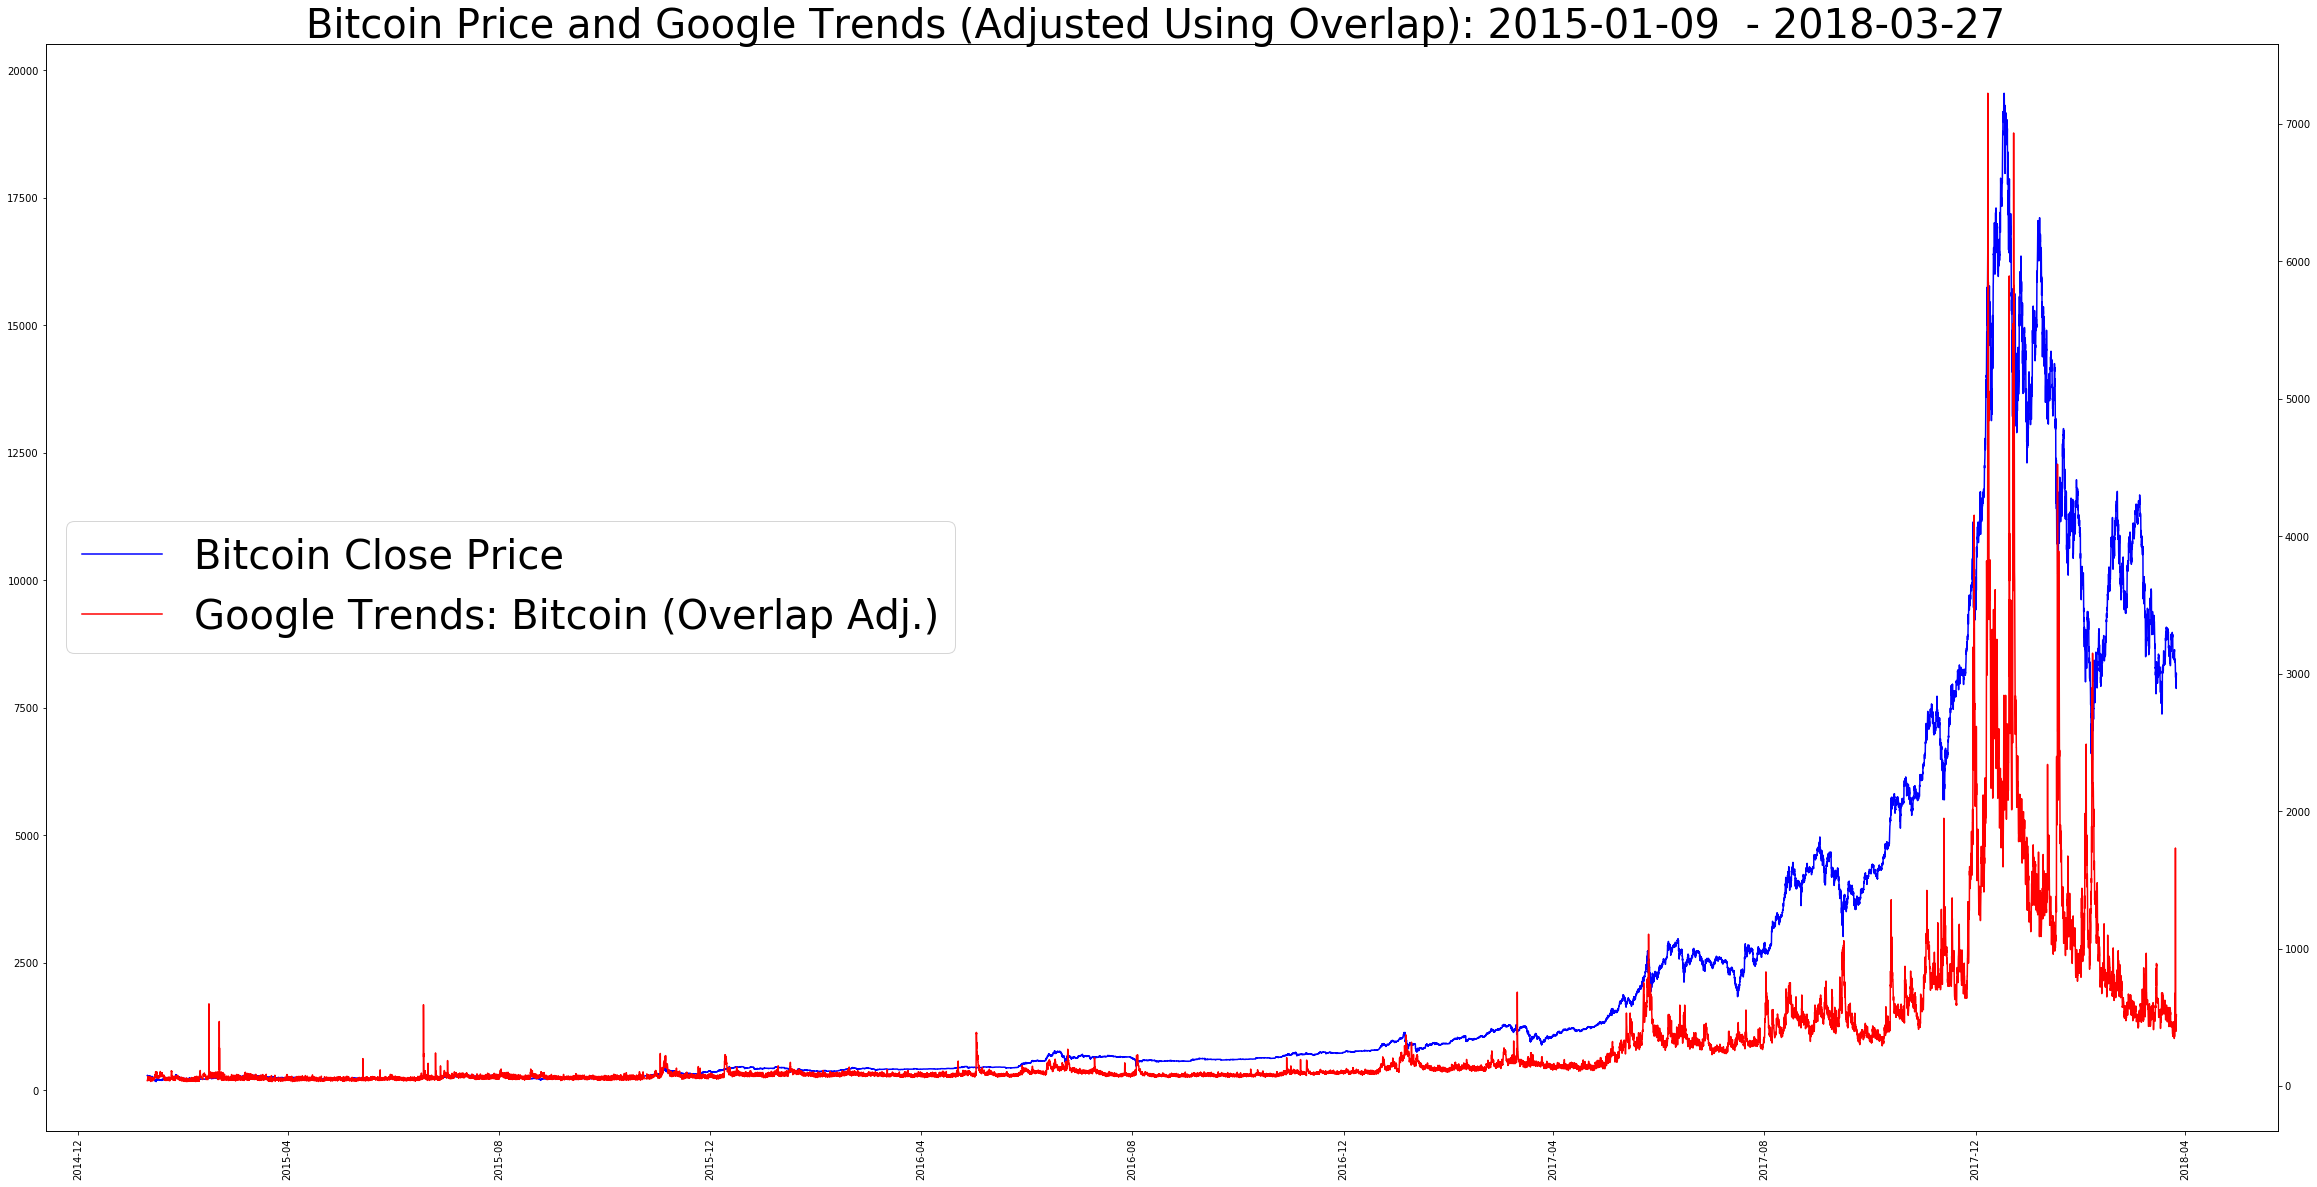

In [7]:
import matplotlib.pyplot as plt

btc_and_trends_df_hourly_overlap = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_overlap_df, right_on="Timestamp")
btc_and_trends_df_hourly_overlap["Close Price % Change"] = btc_and_trends_df_hourly_overlap["Close"].pct_change()
btc_and_trends_df_hourly_overlap["Close Price % Change (Abs)"] = abs(btc_and_trends_df_hourly_overlap["Close Price % Change"])

btc_and_trends_df_hourly_overlap.loc[btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"] == 0] = 1 

display(btc_and_trends_df_hourly_overlap.head(2))

fig_bitcoin_overlap, ax_bitcoin_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_overlap.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close"], color='blue')
ax_bitcoin_overlap_2 = ax_bitcoin_overlap.twinx() 
l2, = ax_bitcoin_overlap_2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_overlap.set_title('Bitcoin Price and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Overlap Adj.)" ], loc=6, fontsize=40)
plt.show();



In [8]:
# writer = pd.ExcelWriter("btc_and_trends_df_hourly_overlap.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# btc_and_trends_df_hourly_overlap.to_excel(writer)
# writer.save()

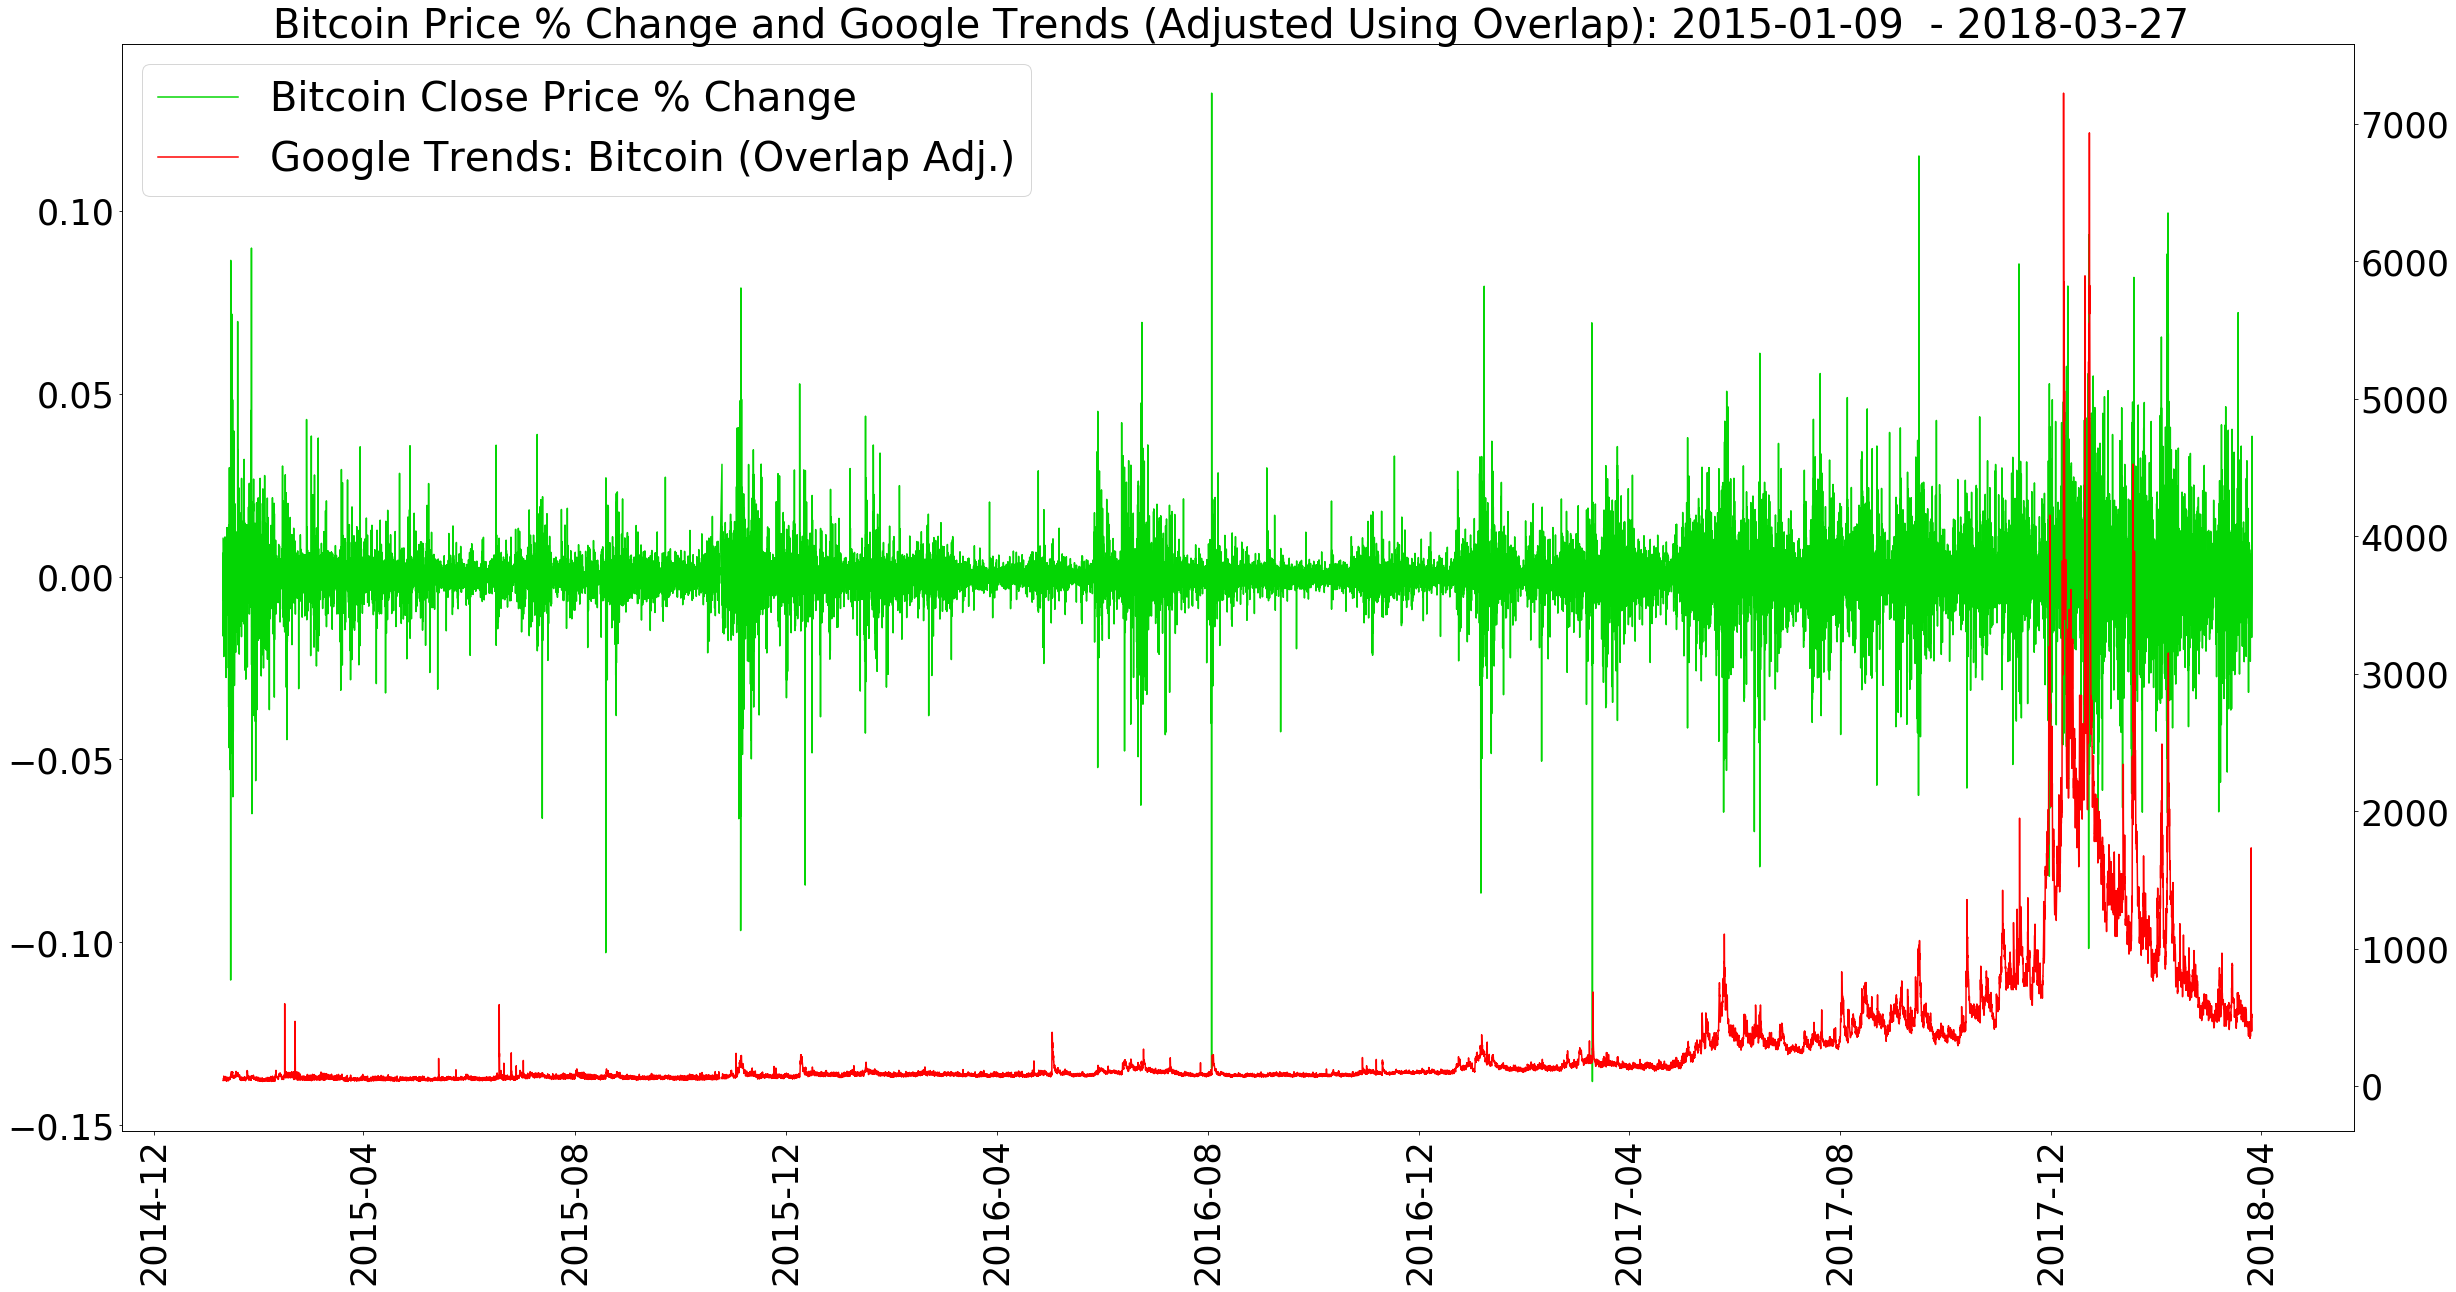

In [9]:
fig, ax = plt.subplots(figsize=(40,20)) 
light_green = '#04D604'
l1, = ax.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close Price % Change"], color=light_green)
ax2 = ax.twinx() 
l2, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax.set_title('Bitcoin Price % Change and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price % Change", "Google Trends: Bitcoin (Overlap Adj.)" ], fontsize=40)
plt.show();

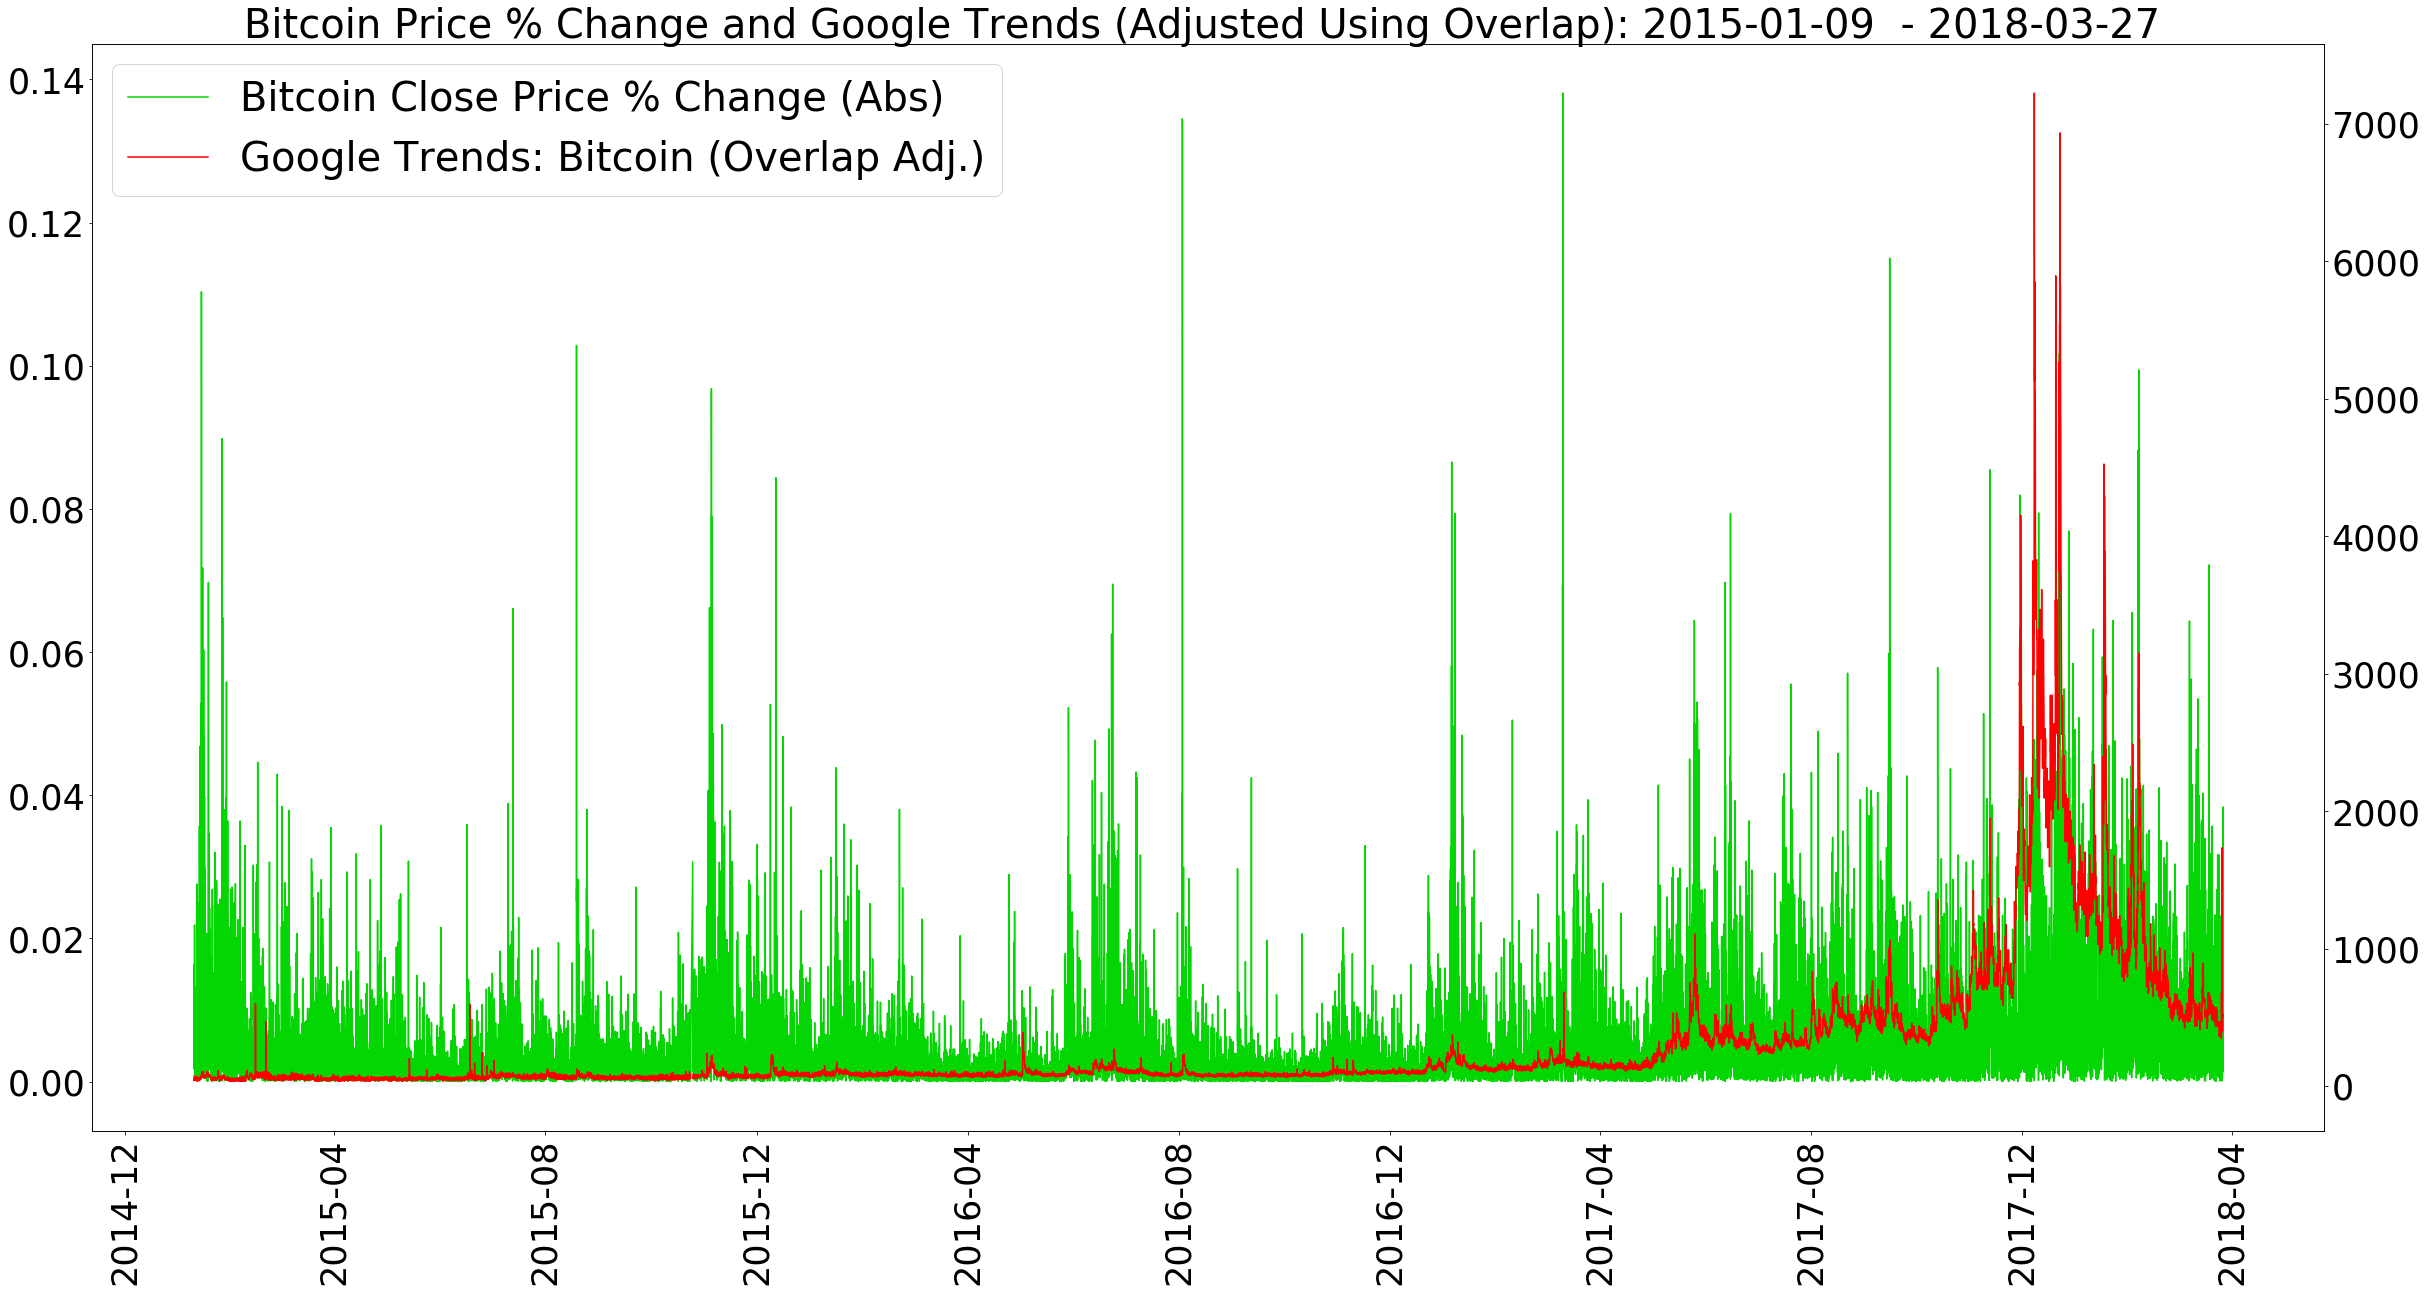

In [10]:
fig, ax = plt.subplots(figsize=(40,20)) 
l1, = ax.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close Price % Change (Abs)"], color=light_green)
ax2 = ax.twinx() 
l2, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax.set_title('Bitcoin Price % Change and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price % Change (Abs)", "Google Trends: Bitcoin (Overlap Adj.)" ], fontsize=40)
plt.show();

In [11]:
# TODO: Investigate if this is merged correctly or not
# btc_and_trends_df_hourly = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_df, right_on="Timestamp")
# display(btc_and_trends_df_hourly.head())

In [12]:
# merge btc_and_trends_df_hourly and btc_and_trends_df_hourly_overlap 

# btc_and_trends_df_hourly["Bitcoin (Adj.Overlap)"] = btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"] 

# display(btc_and_trends_df_hourly.head())

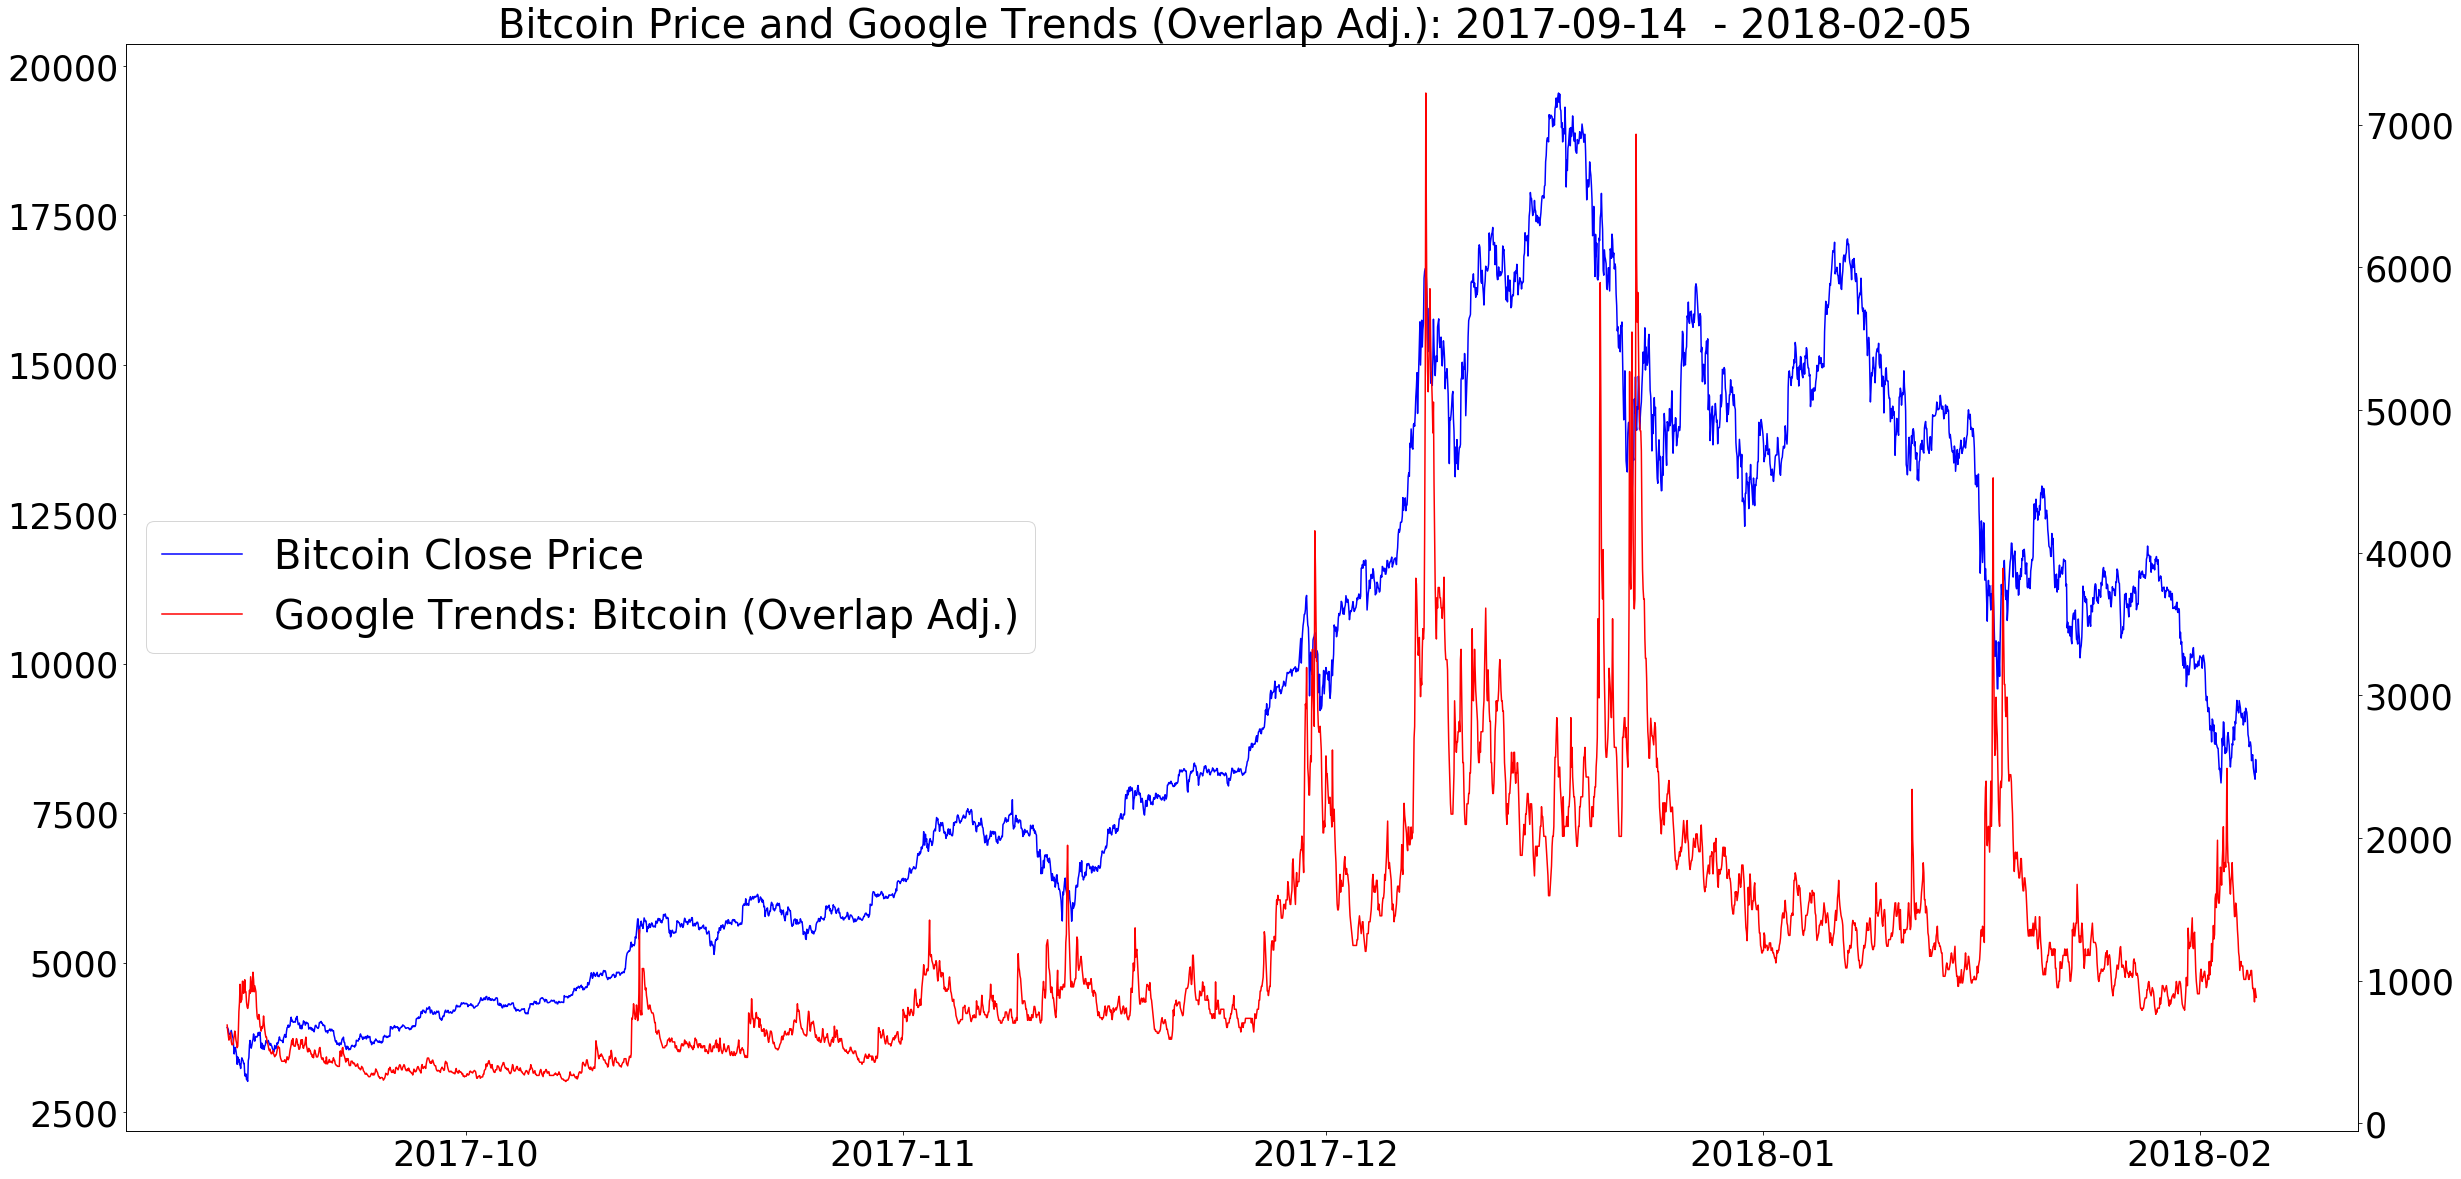

In [13]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Overlap Adjusted Trend Data
sep_2017_to_feb_2018_overlap_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly_overlap["Timestamp"] <=  1517788800) ]

fig_bitcoin_spike_overlap, ax_bitcoin_spike_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike_overlap.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Close"], color='blue')
ax_bitcoin_spike_overlap_2 = ax_bitcoin_spike_overlap.twinx() 
l2, = ax_bitcoin_spike_overlap_2.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_spike_overlap.set_title('Bitcoin Price and Google Trends (Overlap Adj.): ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)
#plt.rcParams.update({'font.size': 15})
plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Overlap Adj.)"], loc=6, fontsize=40)
plt.show();

# blue is price, red is Overlap adjusted data

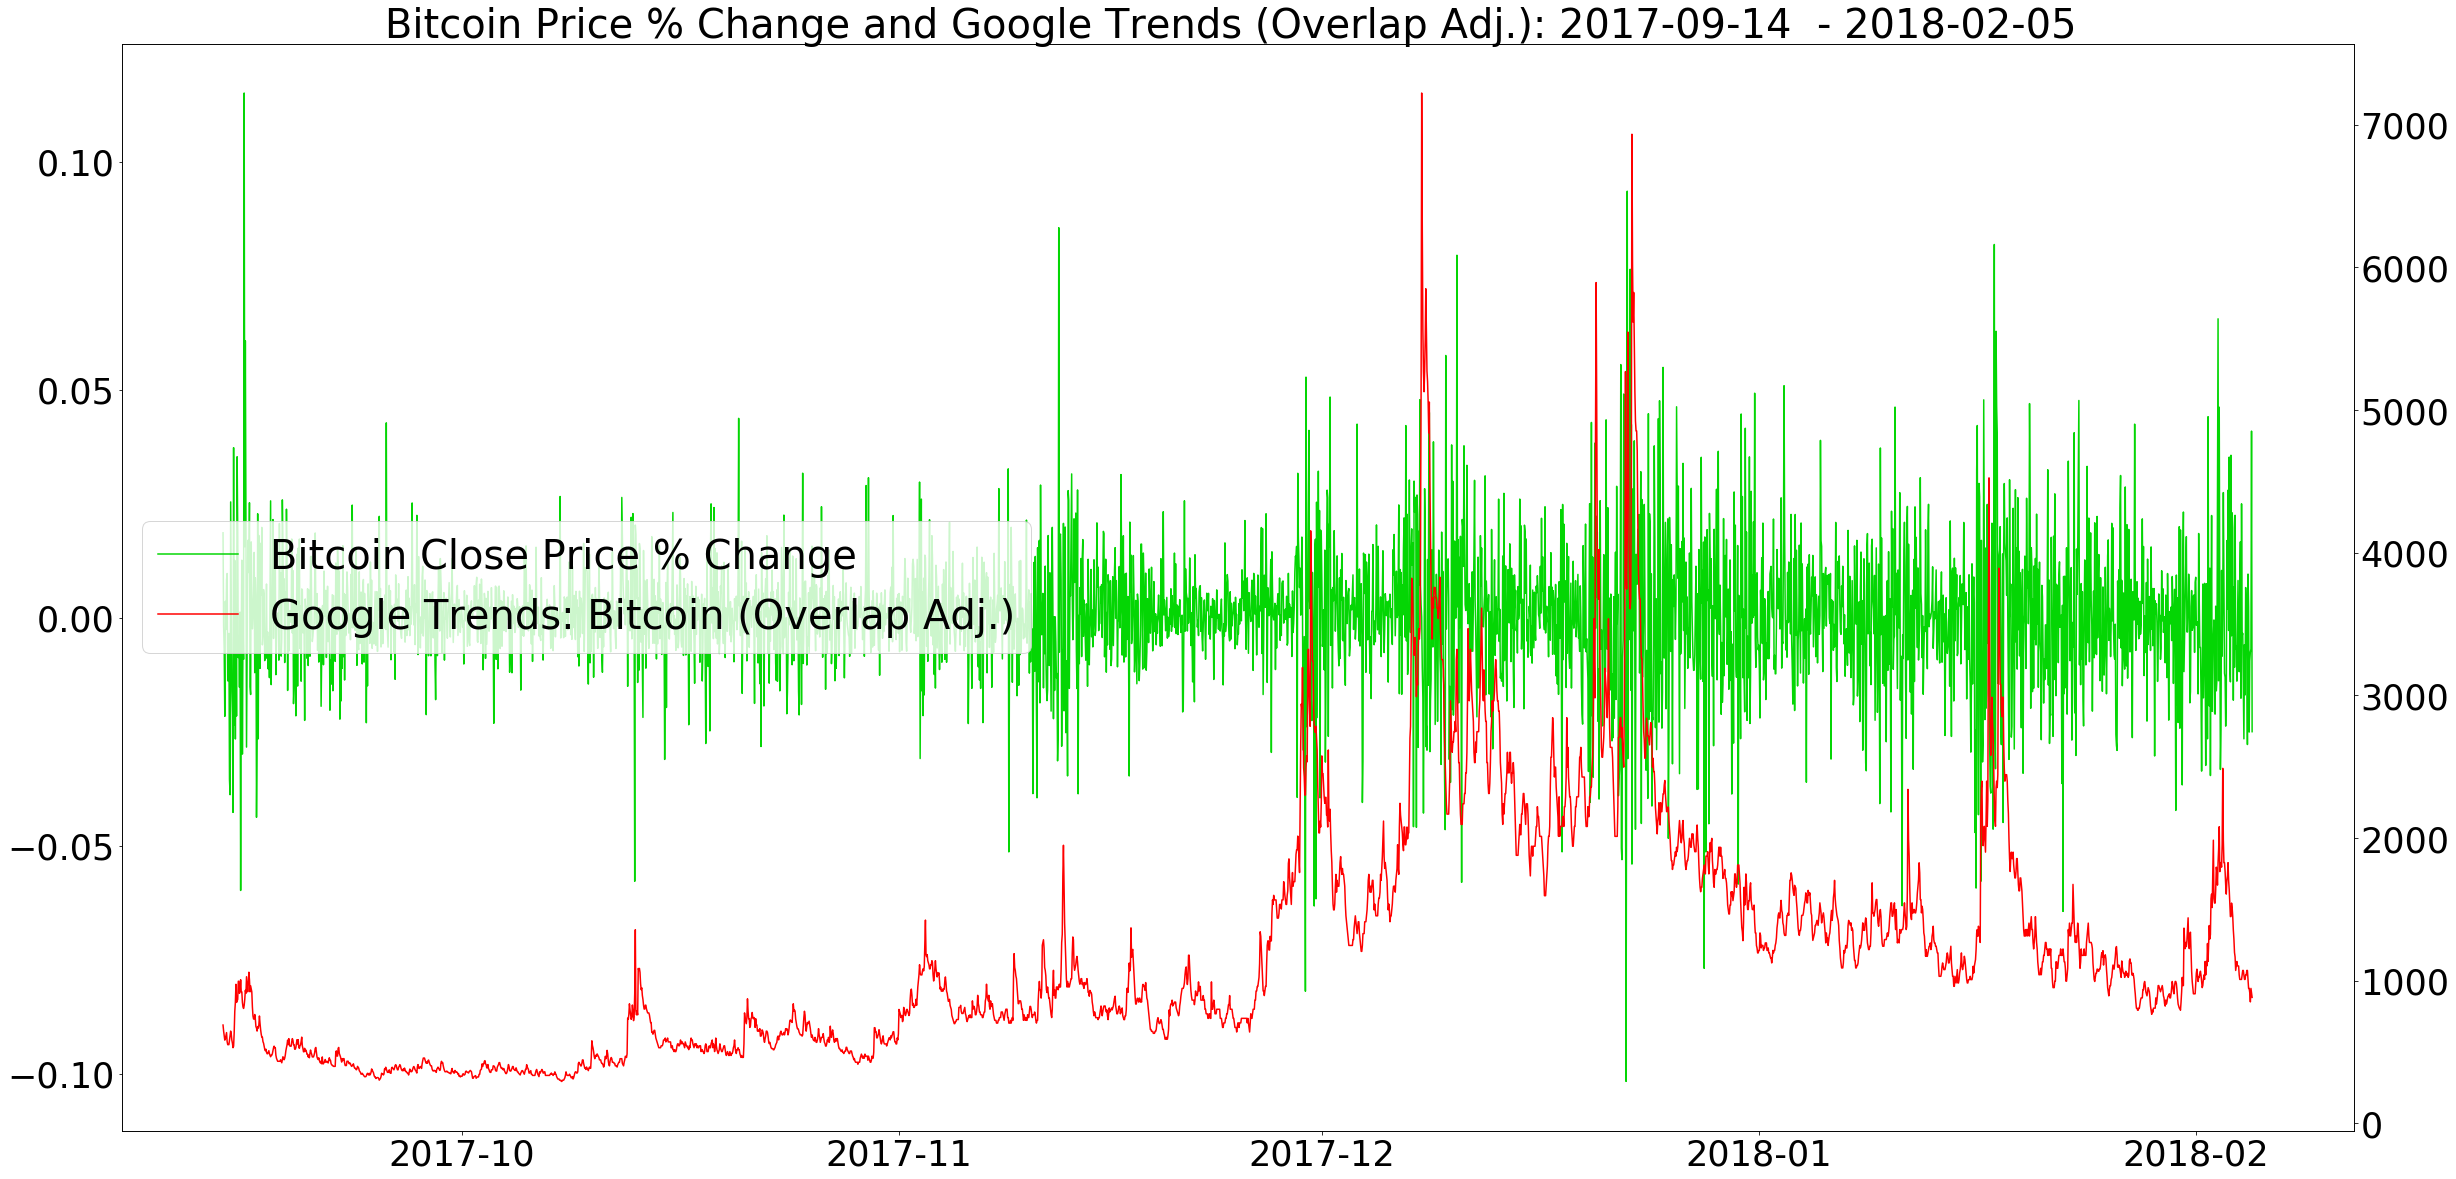

In [14]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Overlap Adjusted Trend Data

fig_bitcoin_spike_overlap, ax_bitcoin_spike_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike_overlap.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Close Price % Change"], color=light_green)
ax_bitcoin_spike_overlap_2 = ax_bitcoin_spike_overlap.twinx() 
l2, = ax_bitcoin_spike_overlap_2.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_spike_overlap.set_title('Bitcoin Price % Change and Google Trends (Overlap Adj.): ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)
#plt.rcParams.update({'font.size': 15})
plt.legend([l1, l2],["Bitcoin Close Price % Change", "Google Trends: Bitcoin (Overlap Adj.)"], loc=6, fontsize=40)
plt.show();

# blue is price, red is Overlap adjusted data

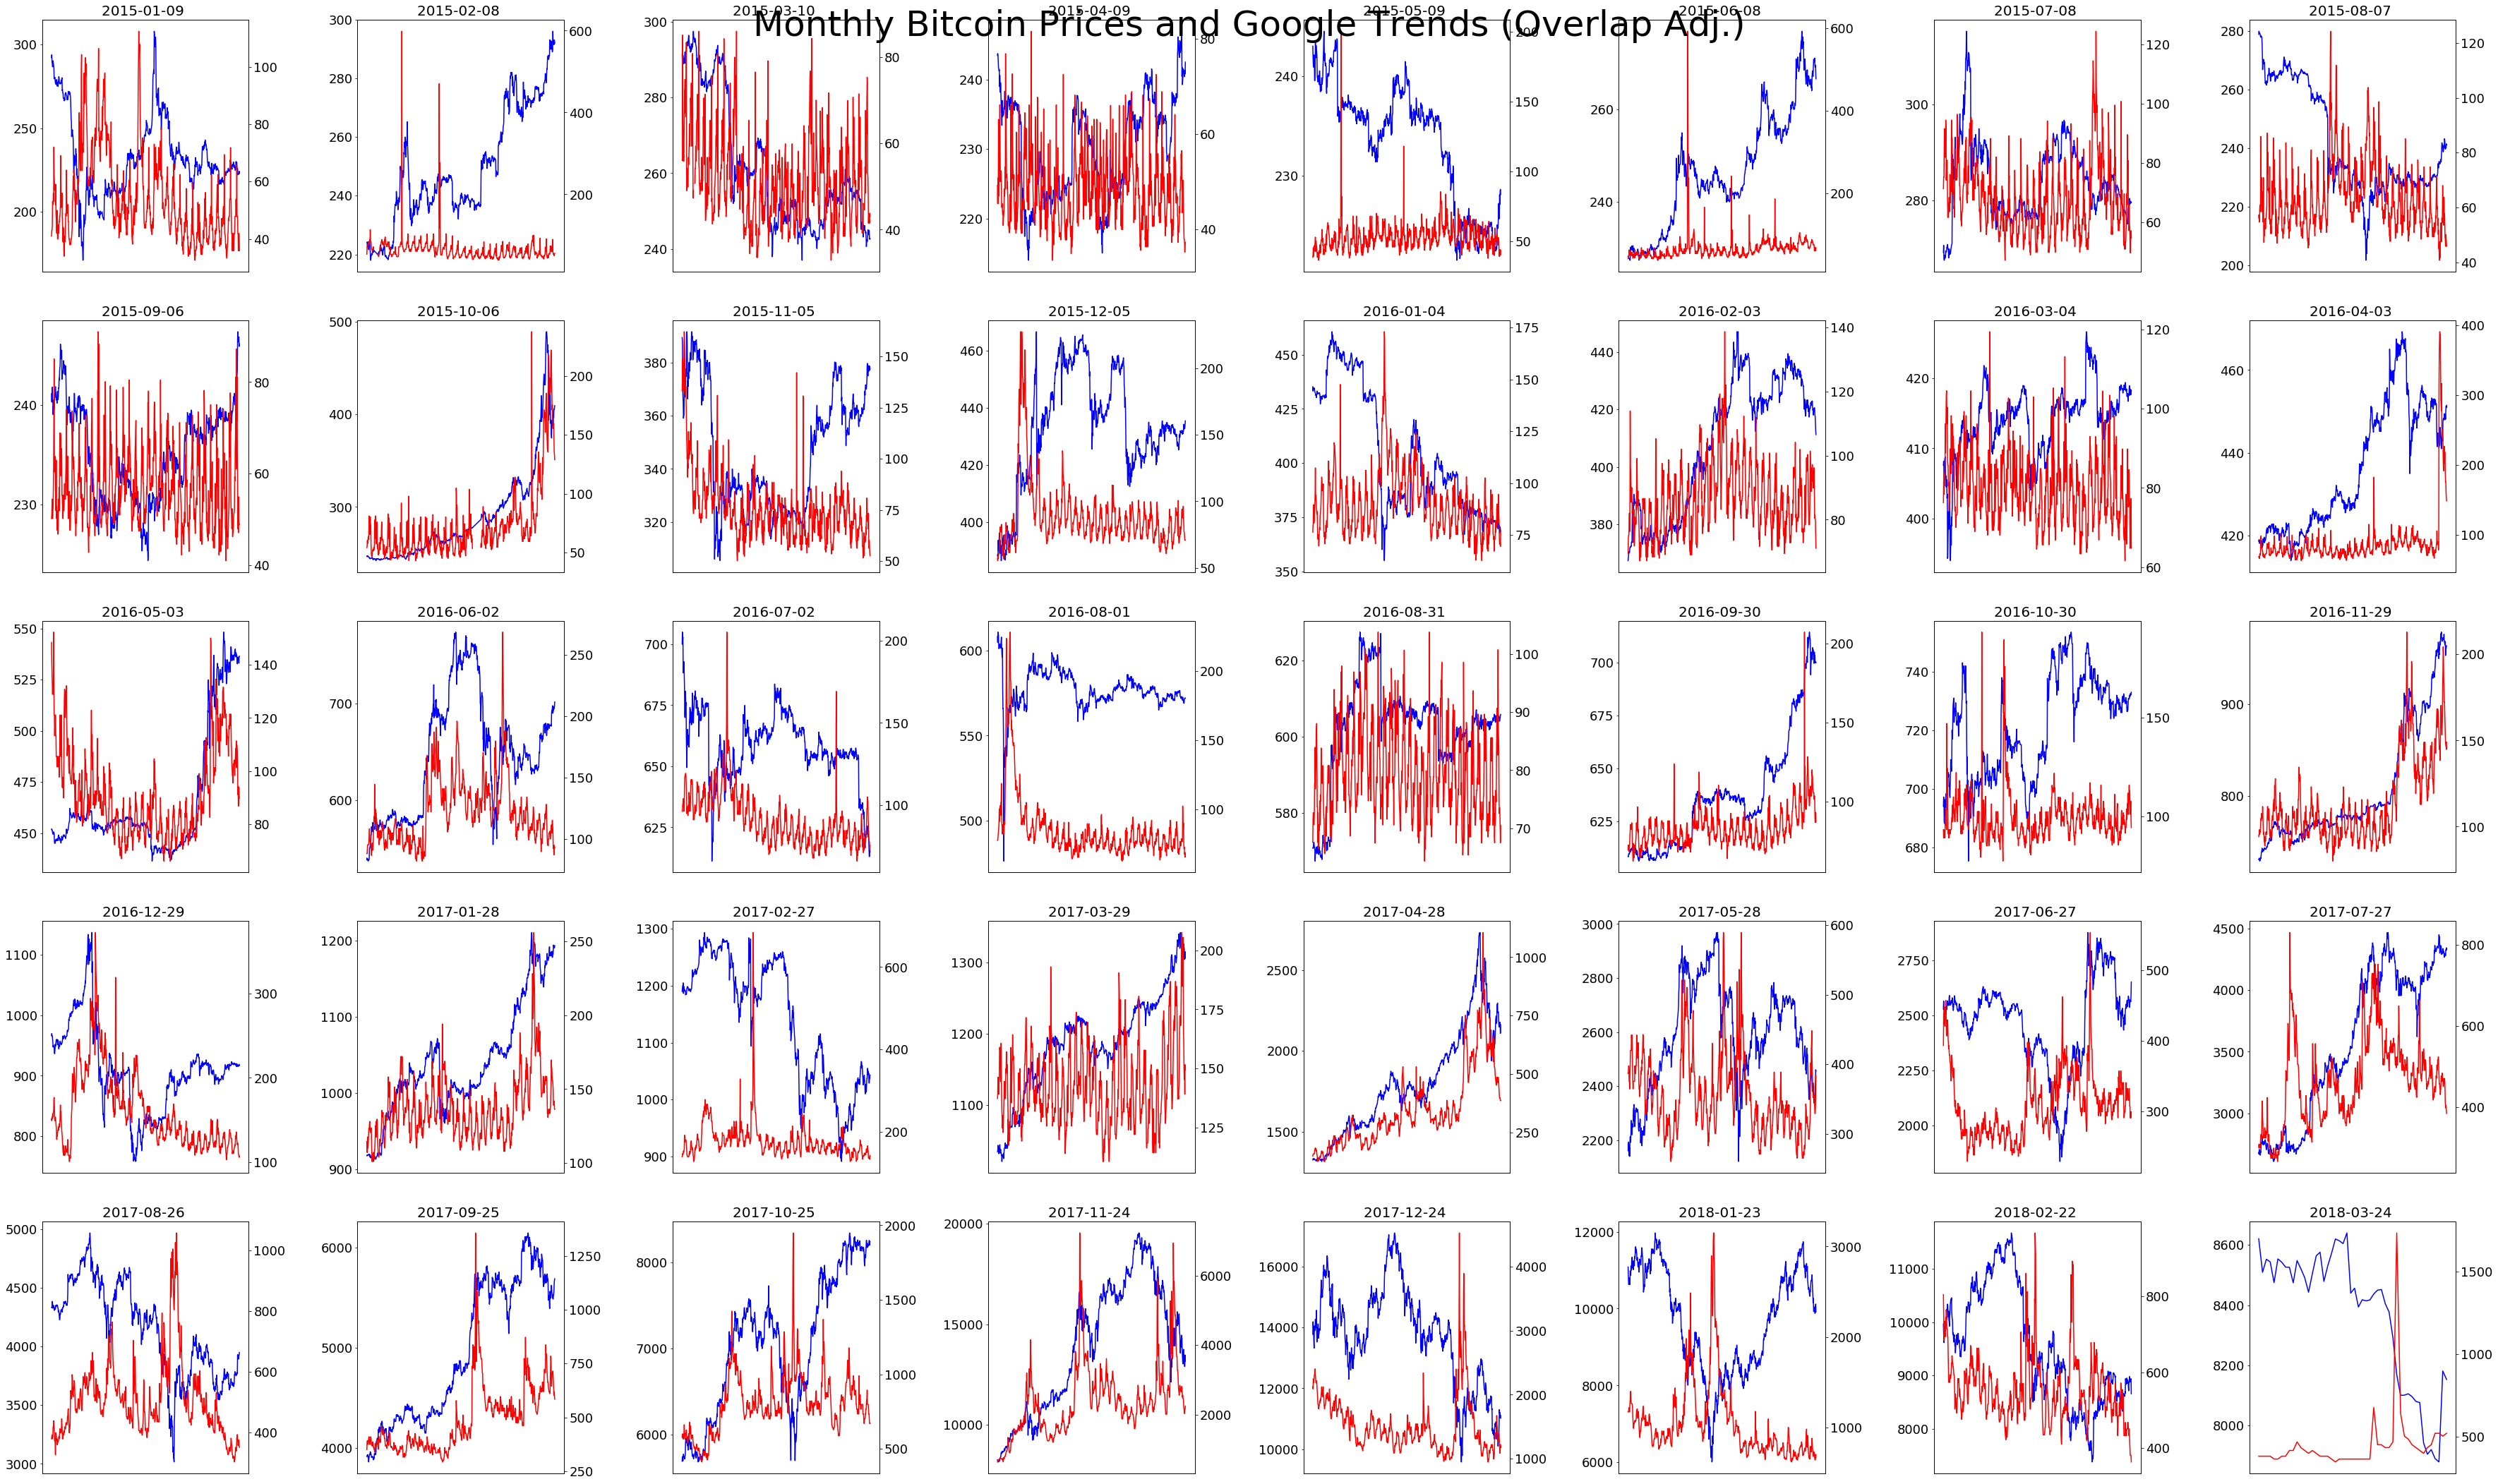

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(50,30), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.Overlap)"], color='red' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8], fontsize=20)
    start_timestamp += 2592000
    for tick in ax.get_yticklabels():
        tick.set_fontsize(18)
    for tick in ax2.get_yticklabels():
        tick.set_fontsize(18)
    ax.set_xticks([])
            
fig.suptitle("Monthly Bitcoin Prices and Google Trends (Overlap Adj.)", fontsize=50)
fig.subplots_adjust(top=0.94)
fig.tight_layout()
plt.show();

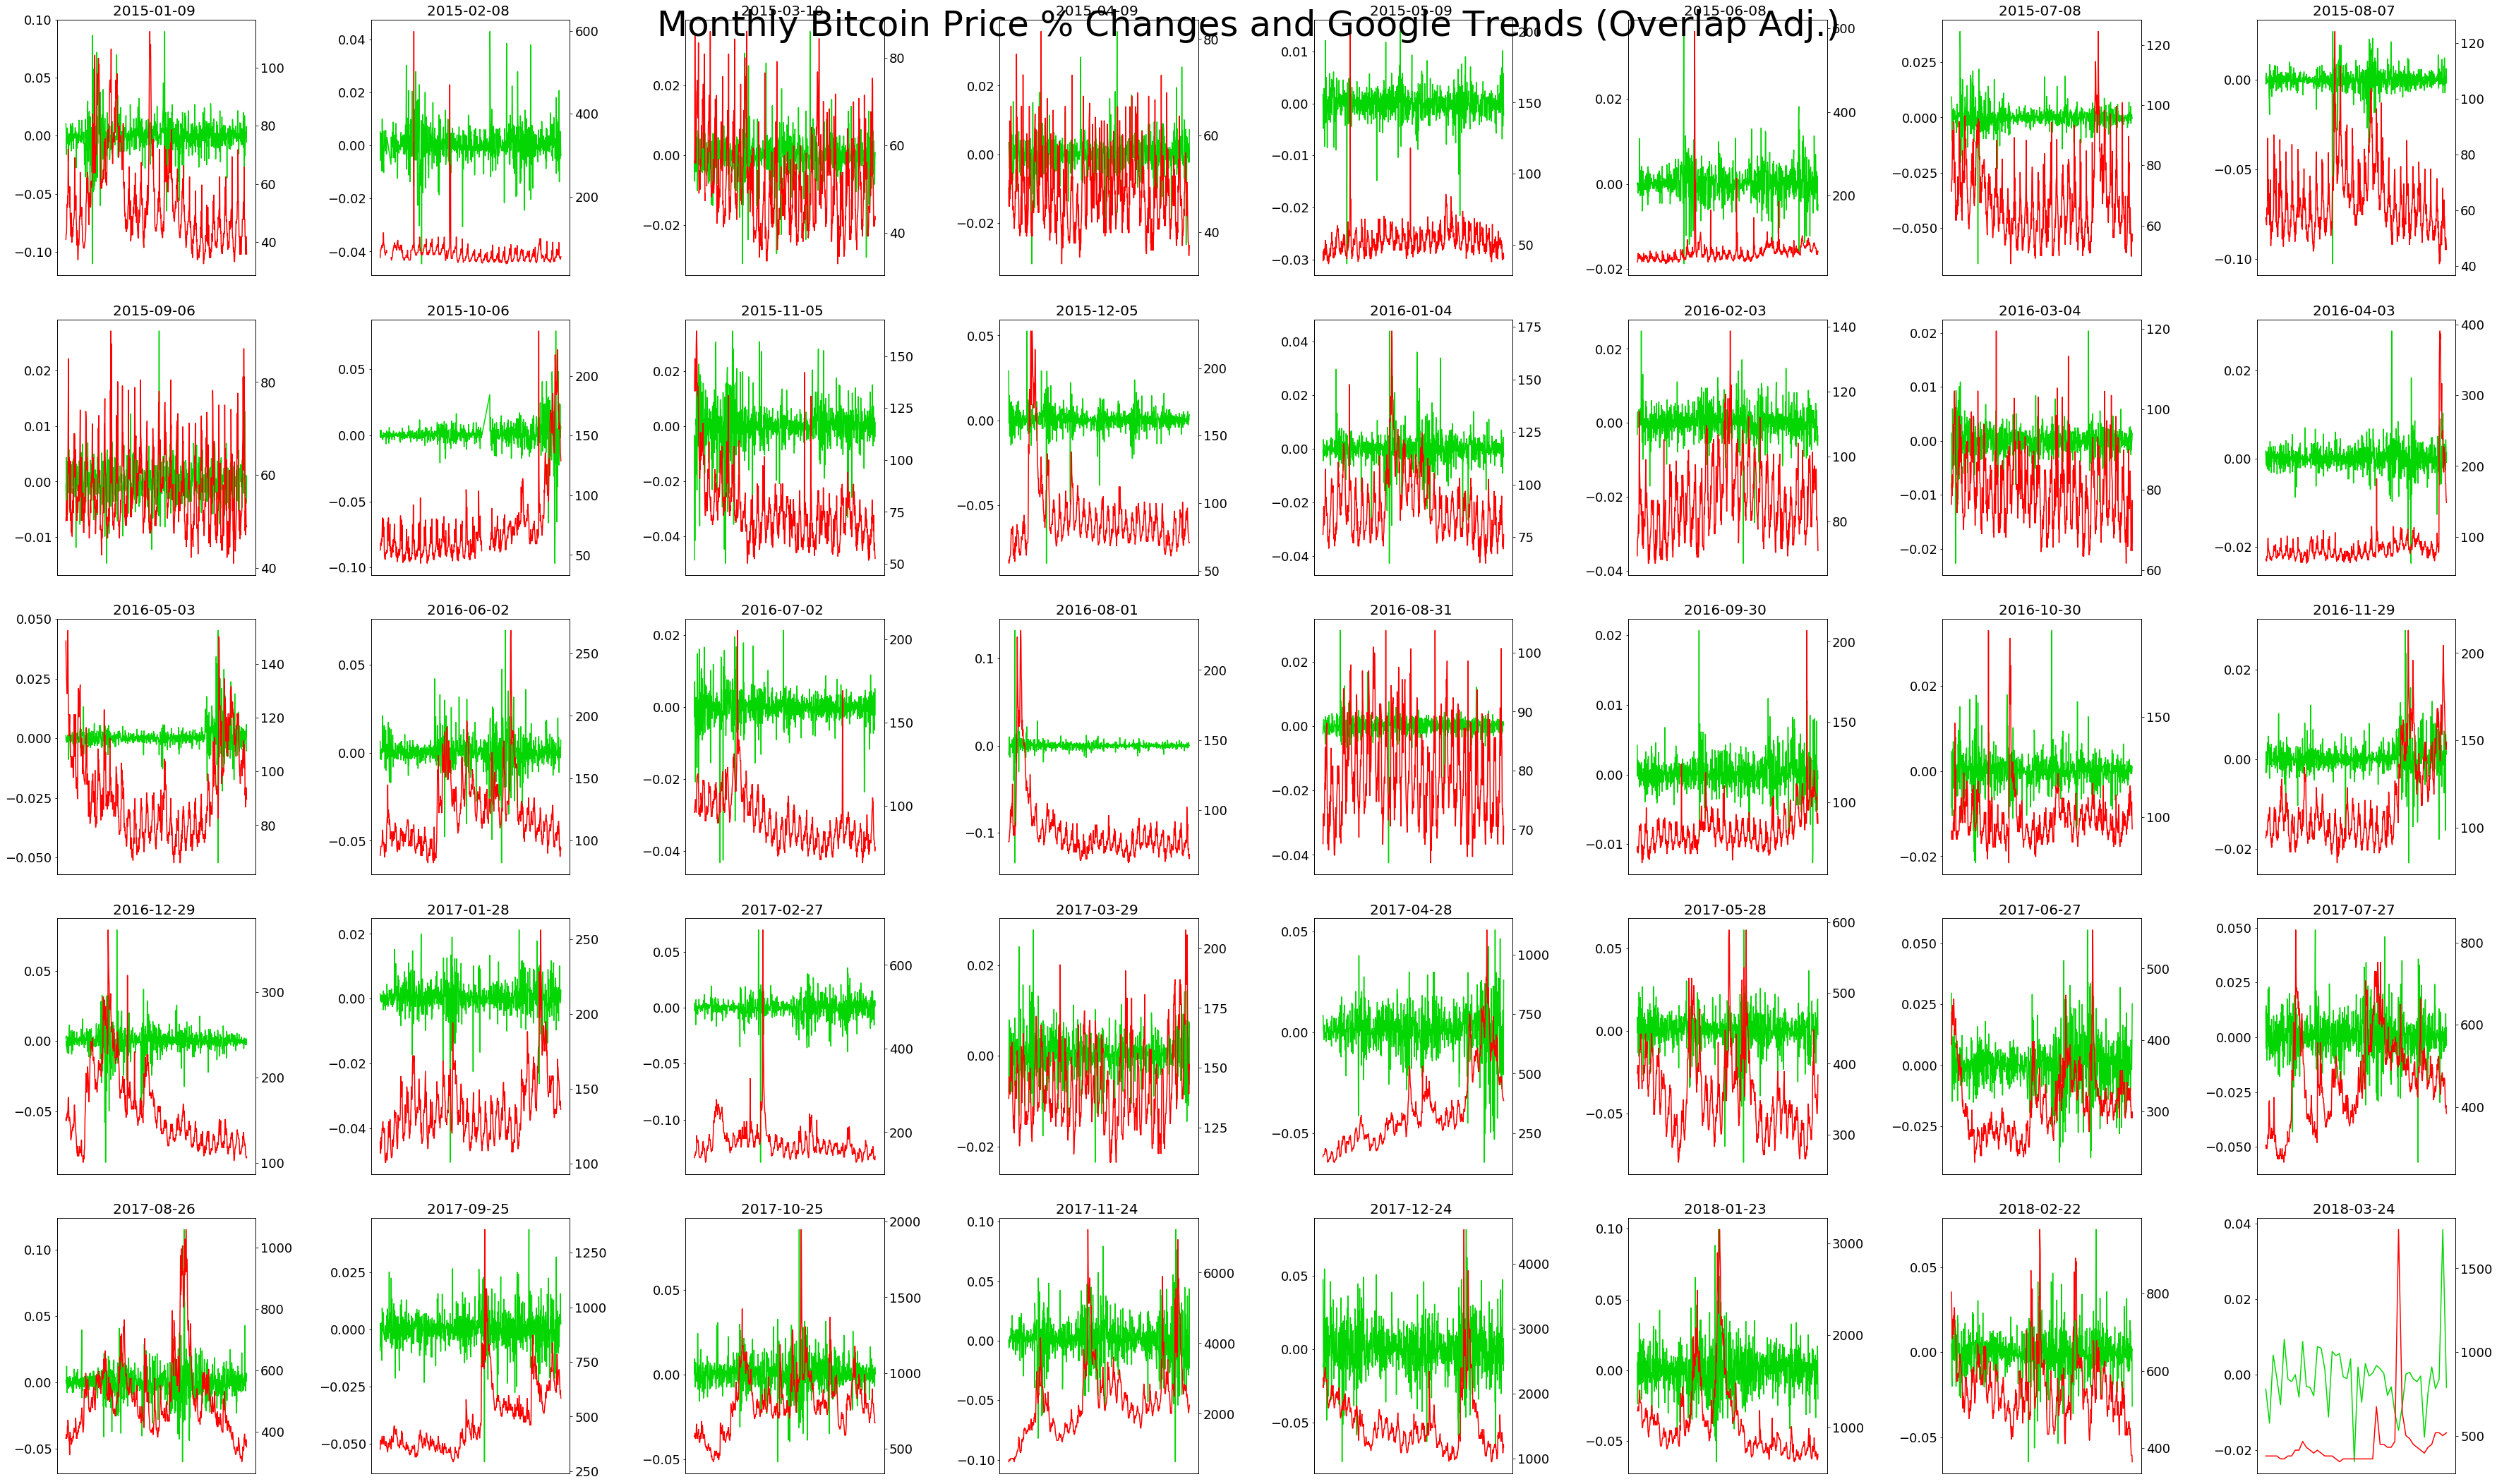

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(50,30), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close Price % Change"], color=light_green)
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.Overlap)"], color='red' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8], fontsize=20)
    start_timestamp += 2592000
    for tick in ax.get_yticklabels():
        tick.set_fontsize(18)
    for tick in ax2.get_yticklabels():
        tick.set_fontsize(18)
    ax.set_xticks([])
            
fig.suptitle("Monthly Bitcoin Price % Changes and Google Trends (Overlap Adj.)", fontsize=50)
fig.subplots_adjust(top=94)
fig.tight_layout()
plt.show();

## Correlation and Anomaly Detection using Luminol

In [17]:
# TODO: Modularize this cell

from luminol.anomaly_detector import AnomalyDetector 
from luminol.correlator import Correlator

# This Cell is for the Historically Adjusted 

# Convert dataframe into dictionary to put into luminol
timestamp_close_df = btc_and_trends_df_hourly_overlap[['Timestamp', 'Close']]
#timestamp_bitcoin_trend_df = btc_and_trends_df_hourly[['Timestamp', "Bitcoin (Adj.)"]]
timestamp_bitcoin_overlap_trend_df = btc_and_trends_df_hourly_overlap[['Timestamp', "Bitcoin (Adj.Overlap)" ]]
display(timestamp_close_df.head())
#display(timestamp_bitcoin_trend_df.head())
display(timestamp_bitcoin_overlap_trend_df.head())

timestamp_close_dict = timestamp_close_df.set_index('Timestamp')['Close'].to_dict()
#timestamp_bitcoin_trend_dict = timestamp_bitcoin_trend_df.set_index('Timestamp')["Bitcoin (Adj.)"].to_dict()
timestamp_bitcoin_trend_overlap_dict = timestamp_bitcoin_overlap_trend_df.set_index('Timestamp')["Bitcoin (Adj.Overlap)"].to_dict()

btc_and_trends_df_hourly_overlap["Is Price Anomaly (Bitmap Detector)"] = 0 

# anomaly detector 
anomaly_detector = AnomalyDetector(timestamp_close_dict)#  , score_percent_threshold=0.5) # Bitmap Detector 
score = anomaly_detector.get_all_scores()

anomaly_df = pd.DataFrame(columns=['Timestamp', 'Date', 'Anomaly Score'])

for timestamp, value in score.iteritems():
    # print anomaly score if greater than 0 
    readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
    #display( str(readable_date) + '->' + str(value))
    anomaly_df = anomaly_df.append({'Timestamp':timestamp, 'Date': readable_date, 'Anomaly Score': value}, ignore_index=True)
    # correlate Close price and Google Trends
    
anomalies = anomaly_detector.get_anomalies()
for anomaly in anomalies:
    time_period = anomaly.get_time_window()
    
#     # to do: tweek the parameters for correlator (like the shift allowed)

    
    start, end = time_period
        
    # set those with anomalies to 1 
    is_in_period = (btc_and_trends_df_hourly_overlap["Timestamp"] > start) & (btc_and_trends_df_hourly_overlap["Timestamp"] < end)
    btc_and_trends_df_hourly_overlap.loc[is_in_period, "Is Price Anomaly (Bitmap Detector)"] = 1 
    
    correlator_overlap = Correlator(timestamp_close_dict, timestamp_bitcoin_trend_overlap_dict, time_period, algorithm_name='cross_correlator', algorithm_params= {'max_shift_seconds':86400})
    if correlator_overlap.is_correlated(threshold=0.5):
        display("Trend data (Overlap Adj.) correlate with Price at time period (%d, %d). There is also an price anomaly during this time." % time_period)
        

display('There were '+ str(len(anomalies))+ ' anomalies in the Timeseries Bitcoin Price data ')

display(anomaly_df.head())

Timestamp   Close
0  1420840800  289.13
1  1420844400  292.15
2  1420848000  293.89
3  1420851600  289.10
4  1420855200  288.59

Timestamp  Bitcoin (Adj.Overlap)
0  1420840800                   40.0
1  1420844400                   41.0
2  1420848000                   43.0
3  1420851600                   43.0
4  1420855200                   45.0

'Trend data (Overlap Adj.) correlate with Price at time period (1507399200, 1508191200). There is also an price anomaly during this time.'

'Trend data (Overlap Adj.) correlate with Price at time period (1511550000, 1512273600). There is also an price anomaly during this time.'

'Trend data (Overlap Adj.) correlate with Price at time period (1512424800, 1513144800). There is also an price anomaly during this time.'

'Trend data (Overlap Adj.) correlate with Price at time period (1514775600, 1514952000). There is also an price anomaly during this time.'

'There were 9 anomalies in the Timeseries Bitcoin Price data '

Timestamp           Date  Anomaly Score
0  1420840800  2015-01-09 17            0.0
1  1420844400  2015-01-09 18            0.0
2  1420848000  2015-01-09 19            0.0
3  1420851600  2015-01-09 20            0.0
4  1420855200  2015-01-09 21            0.0

TODO: get anomalies for the % Change, then plot the anomalies for these against the normal Price Graph

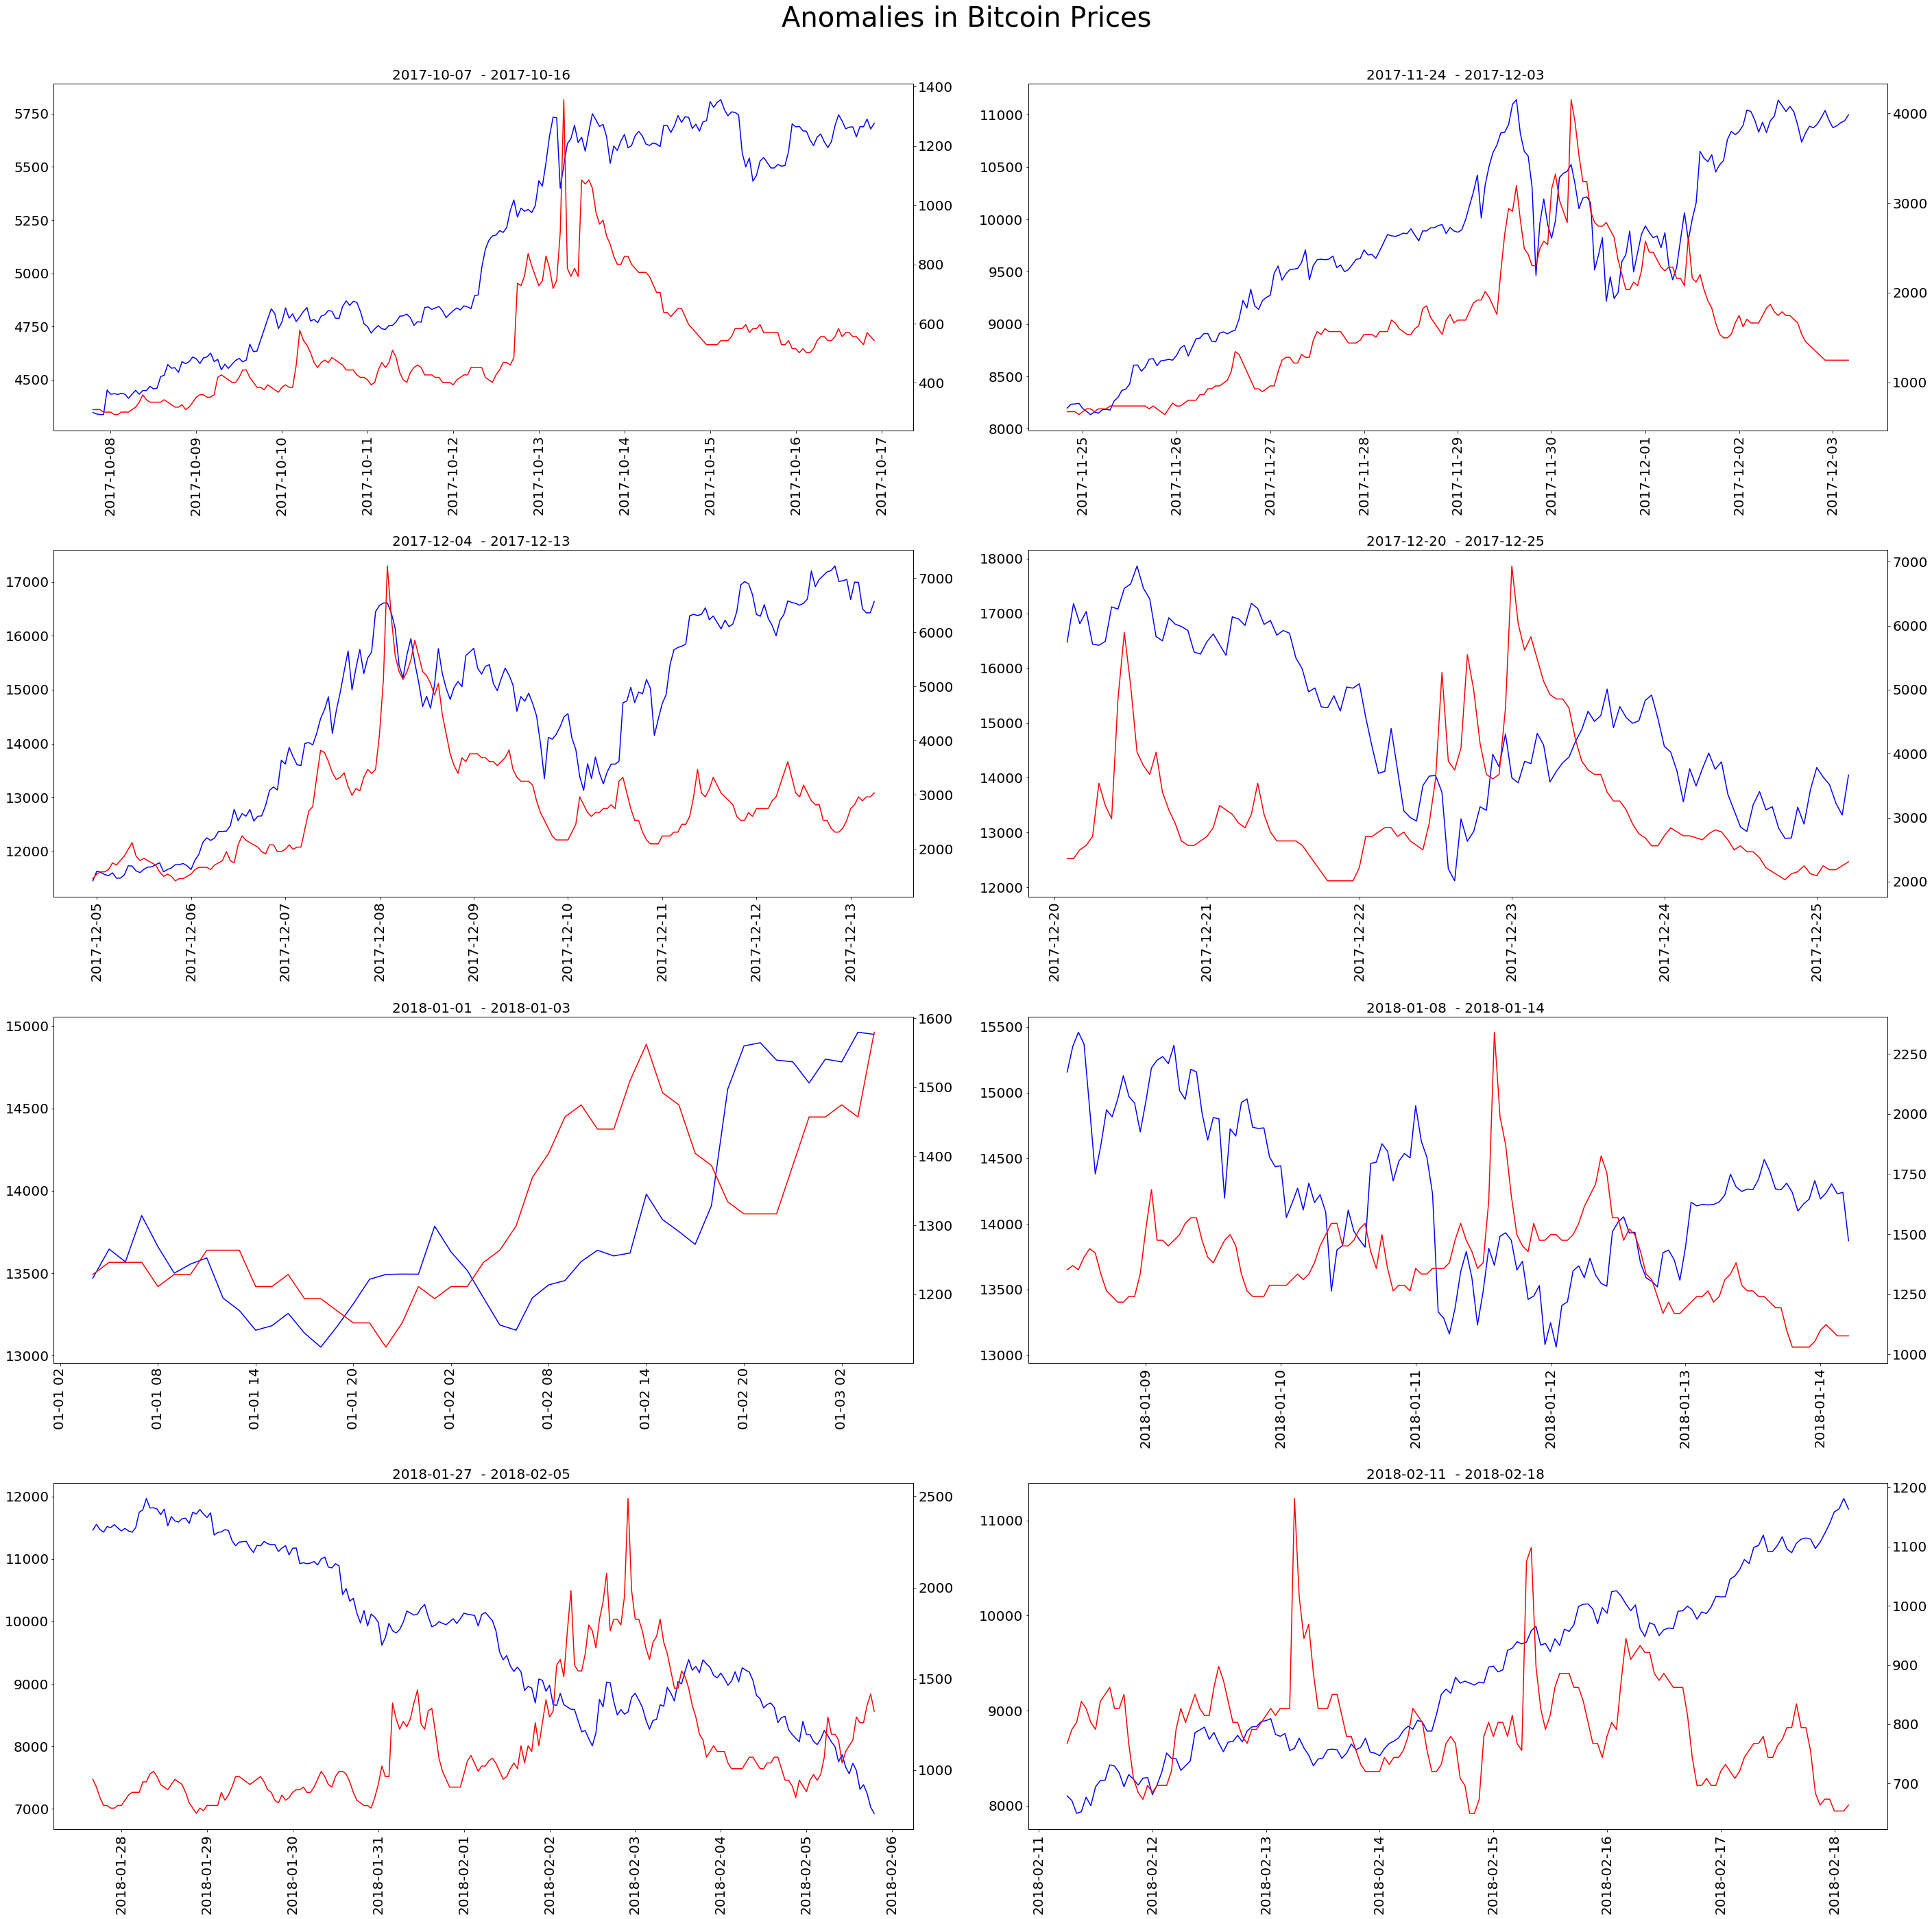

In [18]:
# plots all the anomalies for bitcoin Prices

fig2, axes2 = plt.subplots(nrows=4, ncols=2, figsize=(40,40), sharex=False, sharey=False)

#for i, anomaly in enumerate(anomalies):
for i, ax in enumerate(axes2.flatten()):    
    time_period = anomalies[i].get_time_window()
    start_timestamp = time_period[0]
    end_timestamp = time_period[1] 
        
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= end_timestamp) ]
    #display(in_range_df)
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    
    ax3 = ax.twinx()
    ax3.plot(in_range_df['Date(UTC)'], in_range_df["Bitcoin (Adj.Overlap)"], color='red')
    
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8], fontsize=20 )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(20)
        
        
    axes_list = [ax,ax3]
    for ax in axes_list:
        for tick in ax.get_yticklabels():
            tick.set_fontsize(20)
    
fig2.suptitle("Anomalies in Bitcoin Prices", fontsize=40)
fig2.tight_layout()
fig2.subplots_adjust(top=0.94)
#fig2.subplots_adjust(hspace=2)
plt.show();

# Blue is Price, Orange is Trend. 

In [19]:
# Using different anomaly detection algorithm called Derivative Detector

# (self, time_series, baseline_time_series=None, score_only=False, score_threshold=None,
#          score_percentile_threshold=None, algorithm_name=None, algorithm_params=None,
#          refine_algorithm_name=None, refine_algorithm_params=None)
anomaly_derivative_detector = AnomalyDetector(timestamp_close_dict, score_percent_threshold=0.5, algorithm_name='derivative_detector')
score = anomaly_detector.get_all_scores()

btc_and_trends_df_hourly_overlap["Is Price Anomaly (Derivative Detector)"] = 0 

anomalies_derivative = anomaly_detector.get_anomalies()
for anomaly in anomalies_derivative:
    time_period = anomaly.get_time_window()
    start, end = time_period
        
    # set those with anomalies to 1 
    is_in_period = (btc_and_trends_df_hourly_overlap["Timestamp"] > start) & (btc_and_trends_df_hourly_overlap["Timestamp"] < end)
    btc_and_trends_df_hourly_overlap.loc[is_in_period, "Is Price Anomaly (Derivative Detector)"] = 1 

display('There were '+ str(len(anomalies_derivative))+ ' anomalies in the Timeseries Bitcoin Price data ')
display(btc_and_trends_df_hourly_overlap.head()) 


'There were 9 anomalies in the Timeseries Bitcoin Price data '

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 12:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 13:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 14:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 15:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 16:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   40.0      False 2015-01-09 17:00:00+00:00   
1                   41.0      False 2015-01-09 18:00:00+00:00   
2                   43.0      False 2015-01-09 19:00:00+00:00   
3                   43.0      False 2015-01-09 20:00:00+00:00   
4                   45.0      False 2015-01-09 21:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                40                   NaN                         NaN   
1                41              0.010445                    0.010445   
2                43              0.005956                    0.005956   
3                43             -0.016299                    0.016299   
4                45             -0.001764                    0.001764   

   Is Price Anomaly (Bitmap Detector)  Is Price Anomaly (Derivative Detector)  
0                                   0                                       0  
1                                   0                                       0  
2                                   0                                       0  
3                                   0                                       0  
4                                   0                                       0

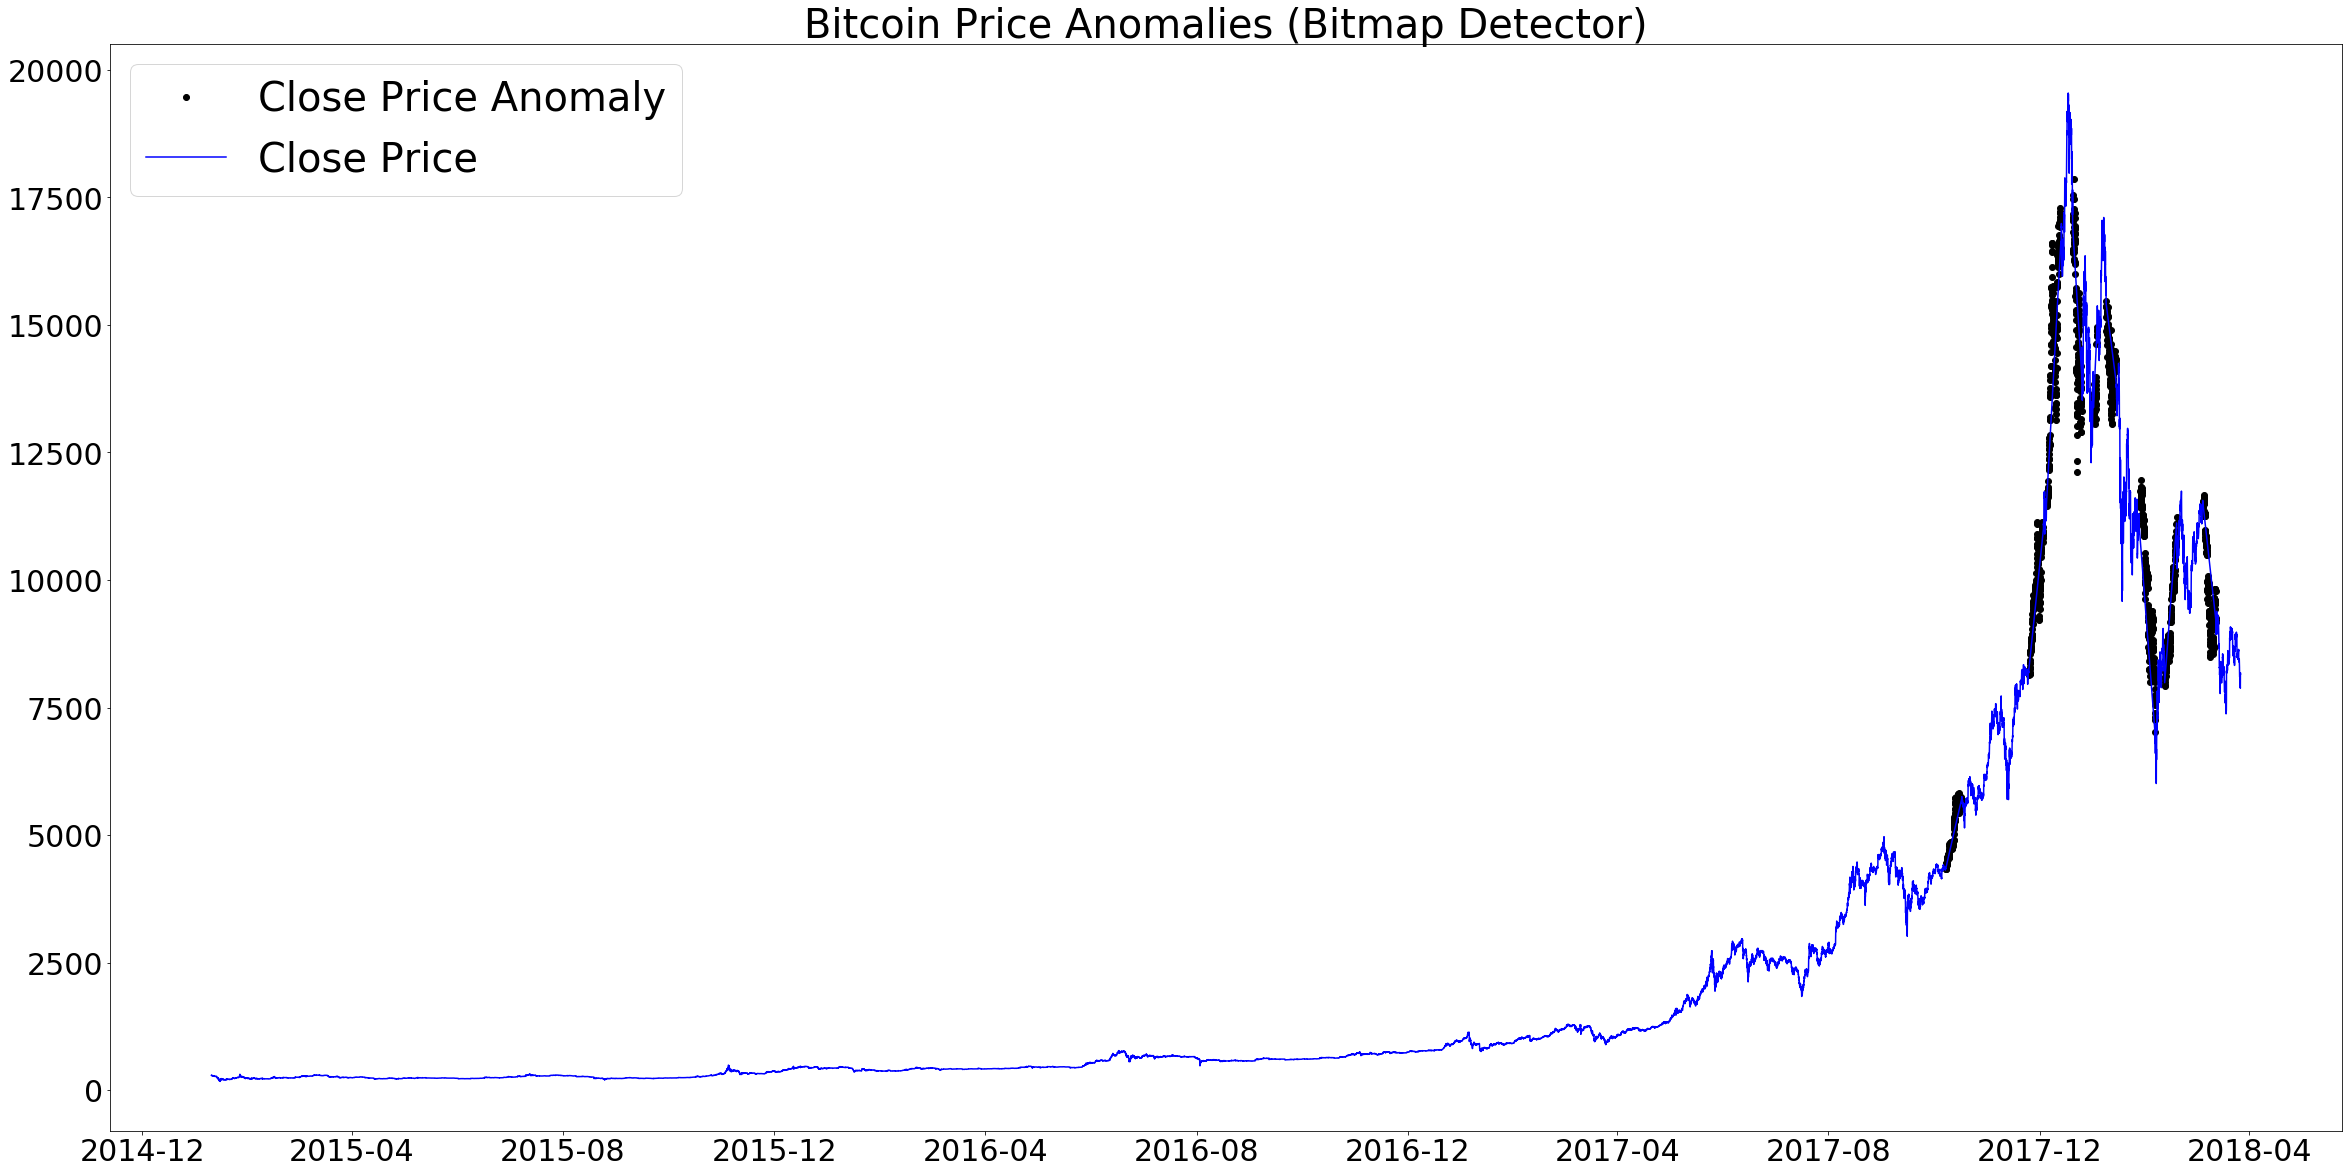

In [20]:
has_anomaly = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Is Price Anomaly (Bitmap Detector)"] == 1]
no_anomaly = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Is Price Anomaly (Bitmap Detector)"] == 0]

fig, ax = plt.subplots(figsize=(40,20))
l1, = ax.plot(has_anomaly["Date(UTC)"], has_anomaly["Close"],color='black', linestyle="None", marker='o')
l2, = ax.plot(no_anomaly["Date(UTC)"], no_anomaly["Close"], color="blue")
ax.set_title("Bitcoin Price Anomalies (Bitmap Detector)", fontsize=40)
for tick in ax.get_xticklabels():
    tick.set_fontsize(30)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30)
plt.legend([l1, l2],["Close Price Anomaly", "Close Price"], fontsize=40)
plt.show() 


Note: Might need to explore other "anomaly detection" options, such as just simply calculating percent differences and deciding on a threshold to decide if something is anomaly or not 

In [21]:
# Find out when Google Trend (Overlap Adj.) data had anomalies 

# Convert dataframe into dictionary to put into luminol

# anomaly detector for google trends
trend_anomaly_detector = AnomalyDetector(timestamp_bitcoin_trend_overlap_dict)
score_trend = trend_anomaly_detector.get_all_scores()

btc_and_trends_df_hourly_overlap["Is Trend Anomaly (Bitmap Detector)"] = 0

trend_anomaly_df = pd.DataFrame(columns=['Timestamp', 'Date', 'Anomaly Score'])

for timestamp, value in score_trend.iteritems():
    # print anomaly score if greater than 0 
    readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
    #display( str(readable_date) + '->' + str(value))
    anomaly_df = anomaly_df.append({'Timestamp':timestamp, 'Date': readable_date, 'Anomaly Score': value}, ignore_index=True)
    
trend_anomalies = trend_anomaly_detector.get_anomalies()
for anomaly in anomalies:
    time_period = anomaly.get_time_window()
    
    start, end = time_period
    is_in_period = (btc_and_trends_df_hourly_overlap["Timestamp"] > start) & (btc_and_trends_df_hourly_overlap["Timestamp"] < end)
    btc_and_trends_df_hourly_overlap.loc[is_in_period, "Is Price Anomaly (Bitmap Detector)"] = 1 
    
    # to do: tweek the parameters for correlator (like the shift allowed)
    correlator_historical = Correlator(timestamp_bitcoin_trend_overlap_dict ,timestamp_close_dict, time_period, algorithm_name='cross_correlator', algorithm_params= {'max_shift_seconds':86400})
    if correlator_historical.is_correlated(threshold=0.5):
        display("Trend data (Historical Adj.) correlate with Price at time period (%d, %d)" % time_period)
    
display('There were '+ str(len(anomalies))+ ' anomalies in the Timeseries Bitcoin Trend (Overlap Adj.) data ')

display(anomaly_df.head())

'Trend data (Historical Adj.) correlate with Price at time period (1507399200, 1508191200)'

'Trend data (Historical Adj.) correlate with Price at time period (1511550000, 1512273600)'

'Trend data (Historical Adj.) correlate with Price at time period (1512424800, 1513144800)'

'Trend data (Historical Adj.) correlate with Price at time period (1514775600, 1514952000)'

'There were 9 anomalies in the Timeseries Bitcoin Trend (Overlap Adj.) data '

Timestamp           Date  Anomaly Score
0  1420840800  2015-01-09 17            0.0
1  1420844400  2015-01-09 18            0.0
2  1420848000  2015-01-09 19            0.0
3  1420851600  2015-01-09 20            0.0
4  1420855200  2015-01-09 21            0.0

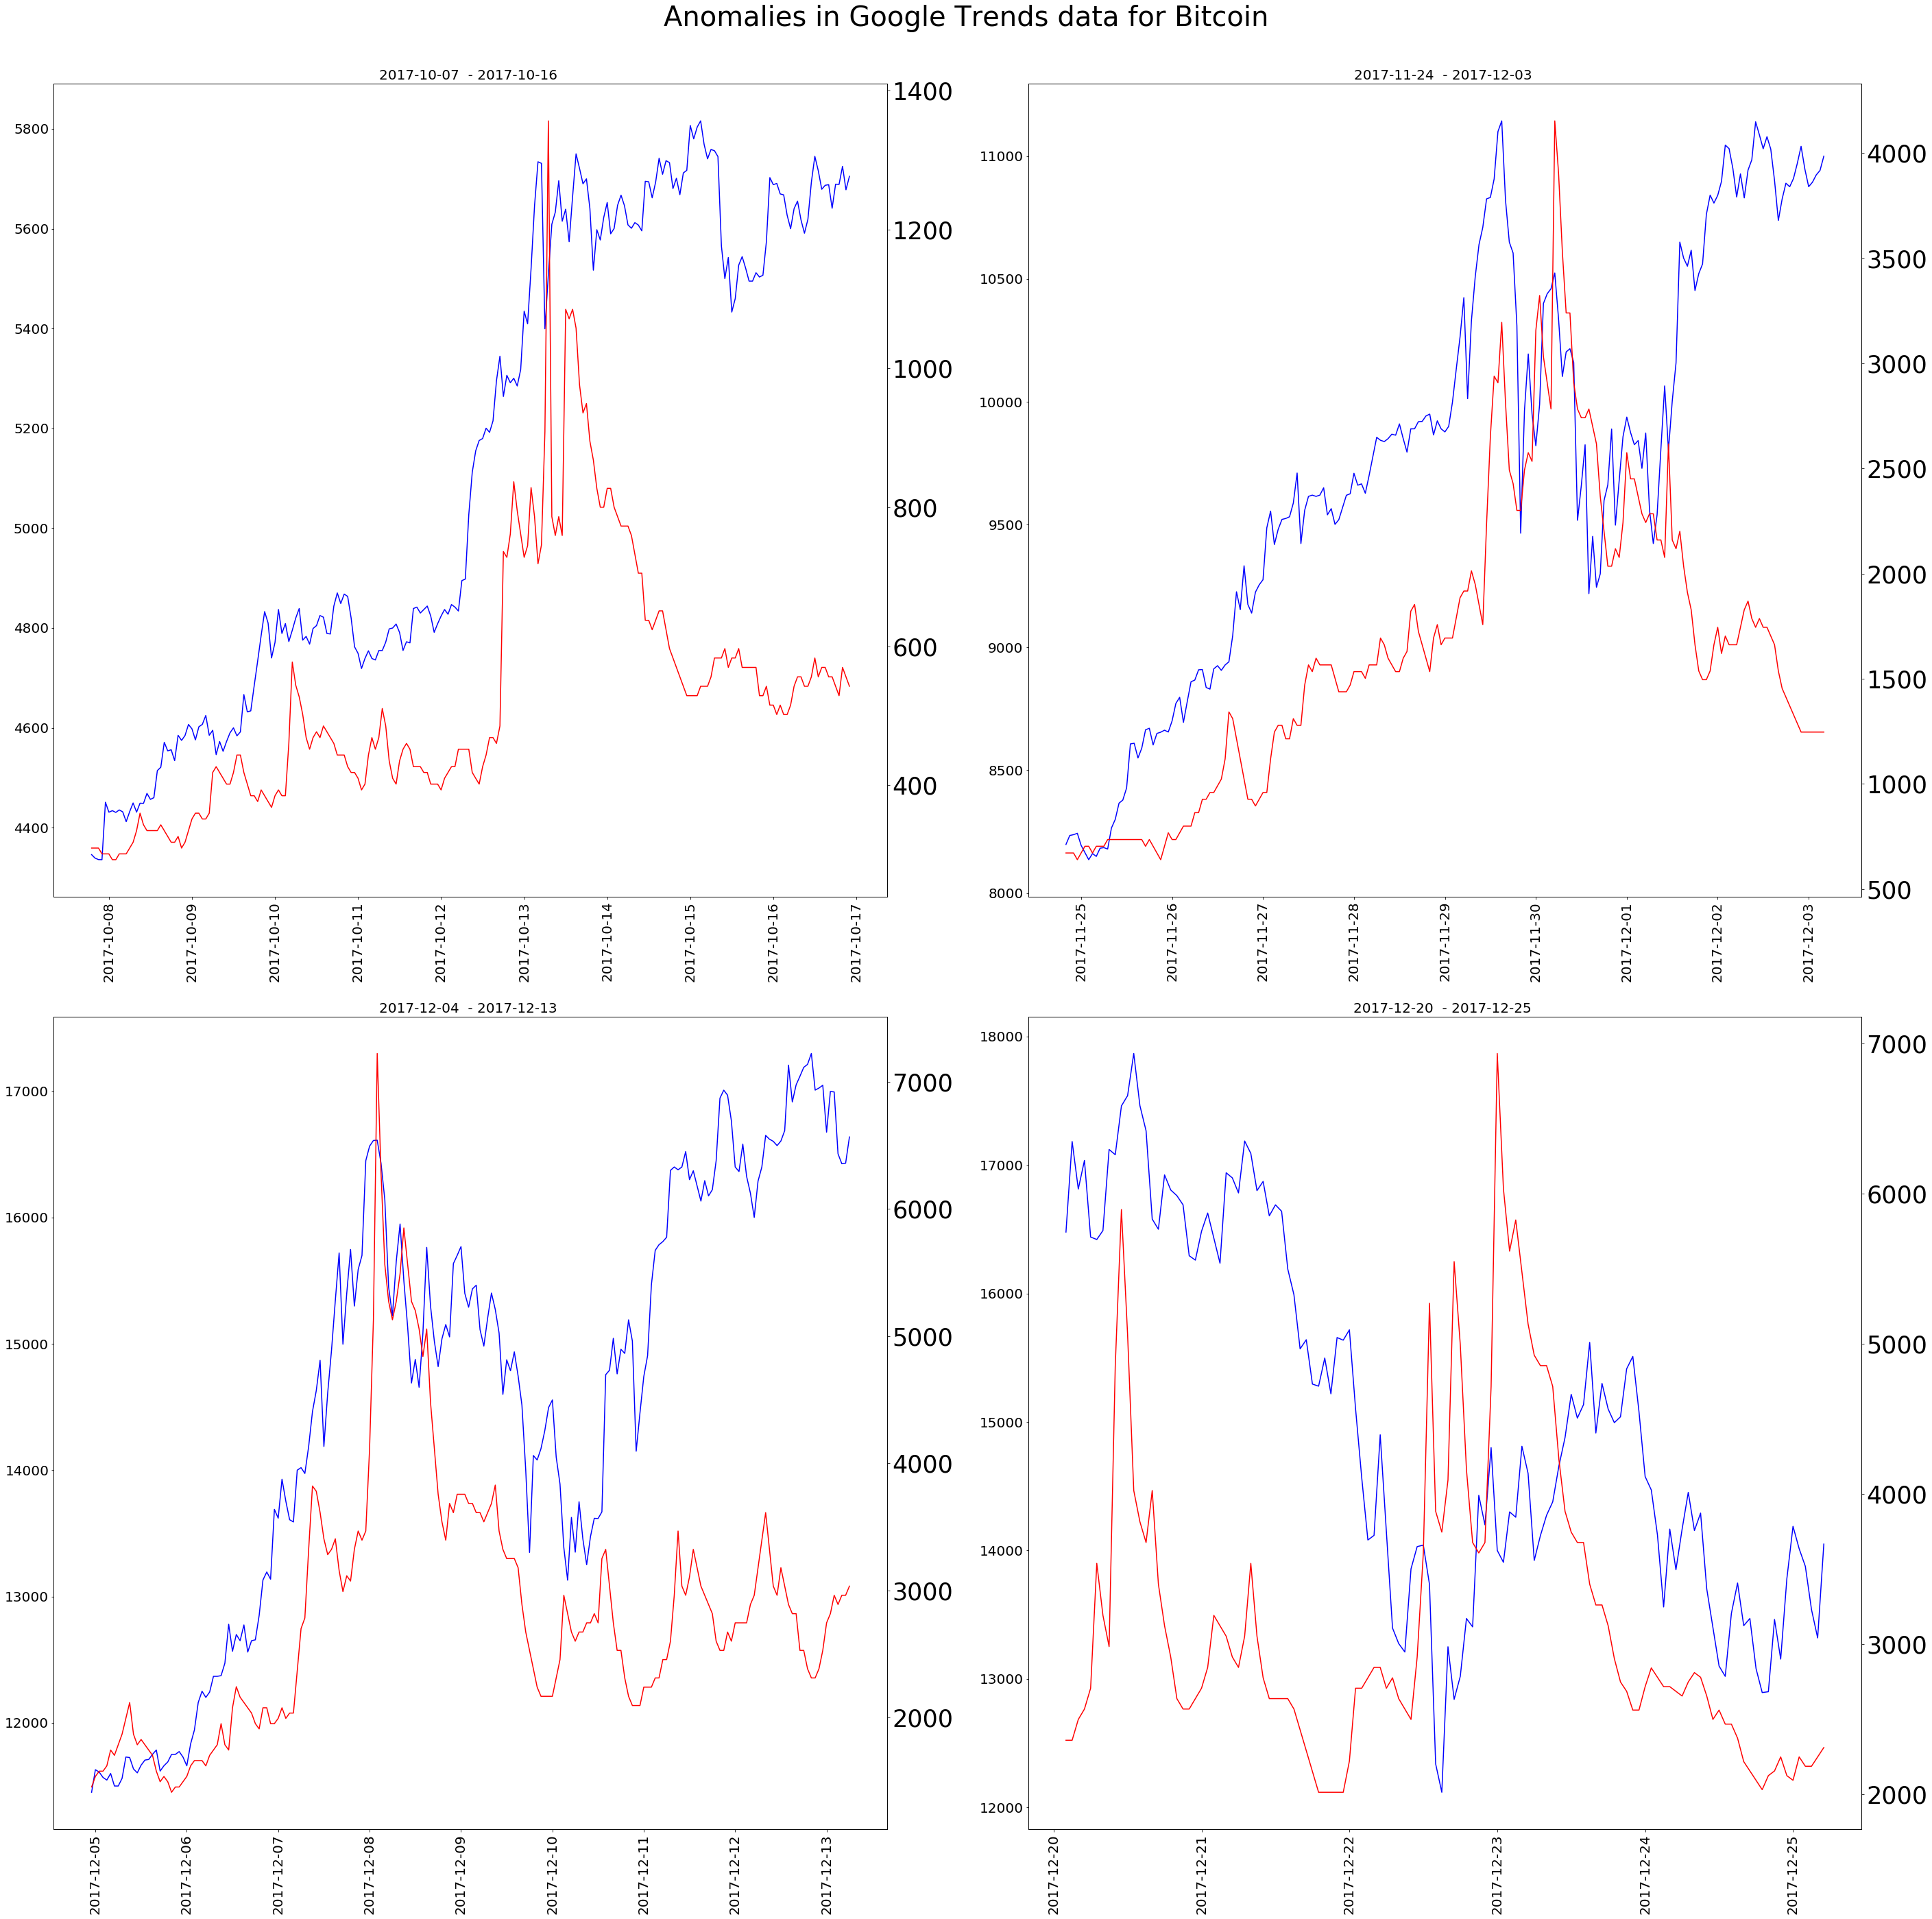

In [22]:
fig3, axes3 = plt.subplots(nrows=2, ncols=2, figsize=(40,40), sharex=False, sharey=False)

#for i, anomaly in enumerate(anomalies):
for i, ax in enumerate(axes3.flatten()):    
    time_period = anomalies[i].get_time_window()
    start_timestamp = time_period[0]
    end_timestamp = time_period[1] 
        
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= end_timestamp) ]
    #display(in_range_df)
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
       
    ax2 = ax.twinx()
    ax2.plot(in_range_df['Date(UTC)'], in_range_df["Bitcoin (Adj.Overlap)"], color='red')
    
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8], fontsize=20 )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(20)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(20)
fig3.suptitle("Anomalies in Google Trends data for Bitcoin", fontsize=40)
fig3.tight_layout()
#fig3.subplots_adjust(hspace=2)
fig3.subplots_adjust(top=0.94)
plt.show();

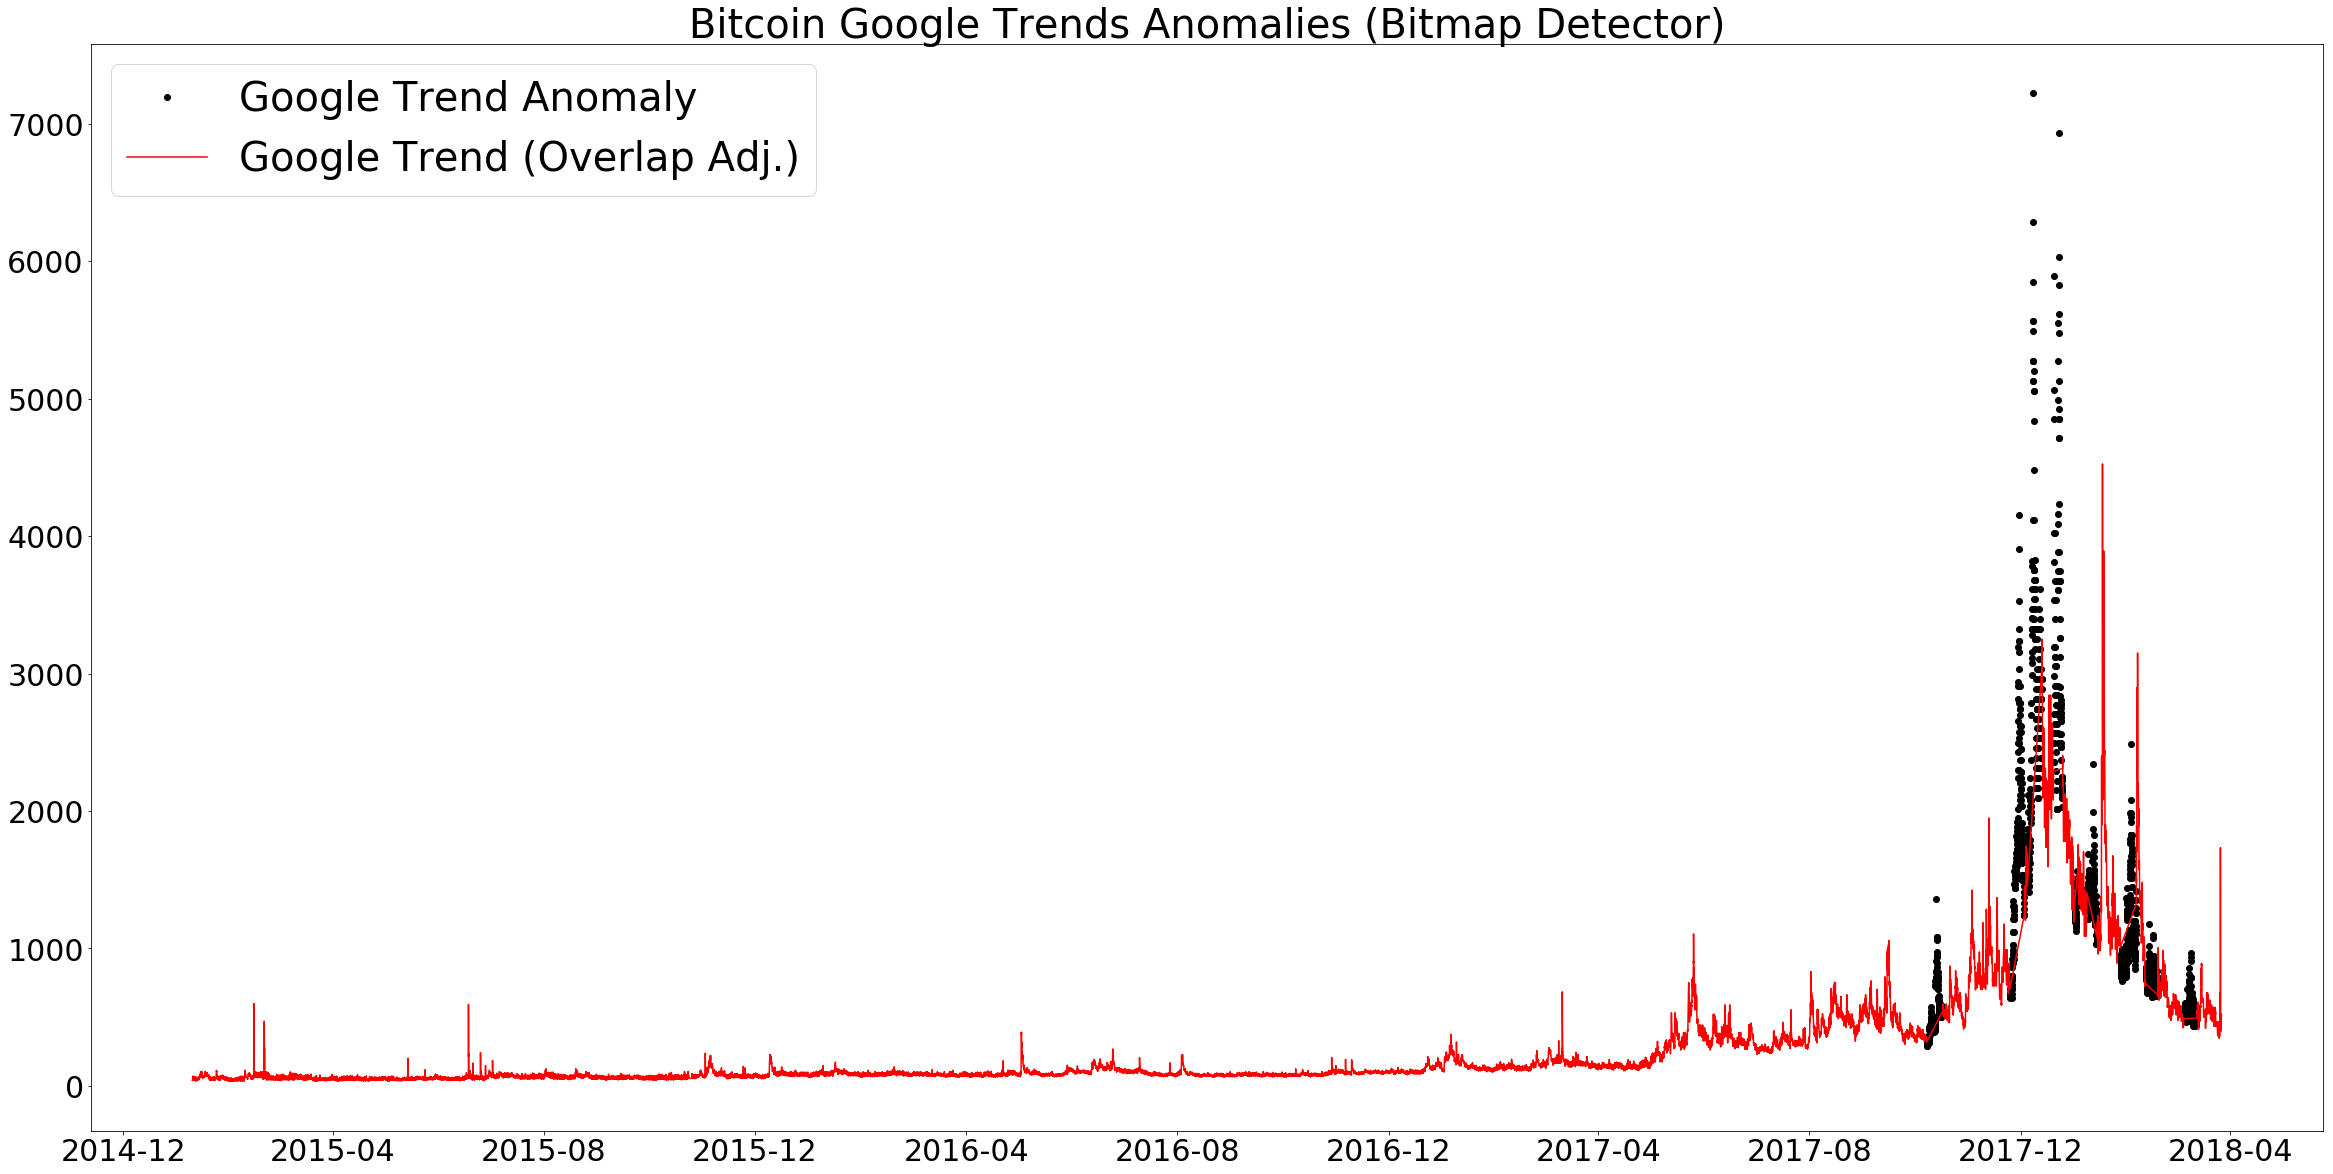

In [23]:
has_trend_anomaly = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Is Trend Anomaly (Bitmap Detector)"] == 1]
no_trend_anomaly = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Is Trend Anomaly (Bitmap Detector)"] == 0]

fig, ax = plt.subplots(figsize=(40,20))
l1, = ax.plot(has_anomaly["Date(UTC)"], has_anomaly["Bitcoin (Adj.Overlap)"],color='black', linestyle="None", marker='o')
l2, = ax.plot(no_anomaly["Date(UTC)"], no_anomaly["Bitcoin (Adj.Overlap)"], color="red")
ax.set_title("Bitcoin Google Trends Anomalies (Bitmap Detector)", fontsize=40)
for tick in ax.get_xticklabels():
    tick.set_fontsize(30)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30)
plt.legend([l1, l2],["Google Trend Anomaly", "Google Trend (Overlap Adj.)"], fontsize=40)
plt.show() 

With a Percentile threshold of 0.900000, the cutoff value is 0.007153


Timestamp    Open    High     Low   Close  Volume_(BTC)  \
5   1420858800  286.66  286.98  286.65  286.70    501.942237   
11  1420880400  280.00  280.00  279.11  279.55     12.271850   
12  1420884000  280.11  280.58  279.60  279.60     14.809935   
43  1420995600  272.97  272.97  272.97  272.97      0.039084   
44  1420999200  271.10  271.10  271.10  271.10      5.713943   

    Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
5       143886.762160      286.660001 2015-01-10 03:00:00 2015-01-09 17:00:00   
11        3429.780674      279.483598 2015-01-10 09:00:00 2015-01-09 23:00:00   
12        4141.657688      279.654017 2015-01-10 10:00:00 2015-01-10 00:00:00   
43          10.668702      272.970000 2015-01-11 17:00:00 2015-01-11 07:00:00   
44        1549.049958      271.100000 2015-01-11 18:00:00 2015-01-11 08:00:00   

             ...                       Date_UTC_trend  Bitcoin (Unadj.)  \
5            ...            2015-01-09 22:00:00+00:00                53   
11           ...            2015-01-10 04:00:00+00:00                62   
12           ...            2015-01-10 05:00:00+00:00                60   
43           ...            2015-01-11 12:00:00+00:00                46   
44           ...            2015-01-11 13:00:00+00:00                41   

   Close Price % Change  Close Price % Change (Abs)  \
5             -0.006549                    0.006549   
11            -0.021868                    0.021868   
12             0.000179                    0.000179   
43             0.002093                    0.002093   
44            -0.006851                    0.006851   

    Is Price Anomaly (Bitmap Detector)  \
5                                    0   
11                                   0   
12                                   0   
43                                   0   
44                                   0   

    Is Price Anomaly (Derivative Detector)  \
5                                        0   
11                                       0   
12                                       0   
43                                       0   
44                                       0   

    Is Trend Anomaly (Bitmap Detector)  Moving Average Price  \
5                                    0            288.130000   
11                                   0            284.016667   
12                                   0            281.650000   
43                                   0            275.166667   
44                                   0            272.156667   

    Moving Average Price % Change  MA % Change (Abs.Value)  
5                       -0.008249                 0.008249  
11                      -0.010533                 0.010533  
12                      -0.008333                 0.008333  
43                      -0.007443                 0.007443  
44                      -0.010939                 0.010939  

[5 rows x 22 columns]

There are 2808 rows above threshold


Timestamp     Open     High      Low    Close  Volume_(BTC)  \
28078  1522094400  7919.99  7920.00  7919.99  7919.99      0.617525   
28079  1522098000  7893.79  7893.79  7888.00  7890.00      2.717707   
28080  1522101600  7887.99  7891.22  7875.76  7879.00      1.141183   
28081  1522105200  8183.25  8192.80  8180.00  8181.23      1.937155   
28082  1522108800  8152.26  8164.68  8151.37  8153.04     17.758130   

       Volume_(Currency)  Weighted_Price           Date(UTC)  \
28078        4890.795926     7919.999335 2018-03-26 20:00:00   
28079       21444.807123     7890.772012 2018-03-26 21:00:00   
28080        9004.457981     7890.459201 2018-03-26 22:00:00   
28081       15856.422940     8185.418647 2018-03-26 23:00:00   
28082      144820.147410     8155.146220 2018-03-27 00:00:00   

                     date           ...                       Date_UTC_trend  \
28078 2018-03-26 10:00:00           ...            2018-03-26 15:00:00+00:00   
28079 2018-03-26 11:00:00           ...            2018-03-26 16:00:00+00:00   
28080 2018-03-26 12:00:00           ...            2018-03-26 17:00:00+00:00   
28081 2018-03-26 13:00:00           ...            2018-03-26 18:00:00+00:00   
28082 2018-03-26 14:00:00           ...            2018-03-26 19:00:00+00:00   

       Bitcoin (Unadj.) Close Price % Change  Close Price % Change (Abs)  \
28078                26             0.001950                    0.001950   
28079                30            -0.003787                    0.003787   
28080                30            -0.001394                    0.001394   
28081                29             0.038359                    0.038359   
28082                30            -0.003446                    0.003446   

       Is Price Anomaly (Bitmap Detector)  \
28078                                   0   
28079                                   0   
28080                                   0   
28081                                   0   
28082                                   0   

       Is Price Anomaly (Derivative Detector)  \
28078                                       0   
28079                                       0   
28080                                       0   
28081                                       0   
28082                                       0   

       Is Trend Anomaly (Bitmap Detector)  Moving Average Price  \
28078                                   0           7922.190000   
28079                                   0           7904.856667   
28080                                   0           7896.330000   
28081                                   0           7983.410000   
28082                                   0           8071.090000   

       Moving Average Price % Change  MA % Change (Abs.Value)  
28078                      -0.006538                 0.006538  
28079                      -0.002188                 0.002188  
28080                      -0.001079                 0.001079  
28081                       0.011028                 0.011028  
28082                       0.010983                 0.010983  

[5 rows x 22 columns]

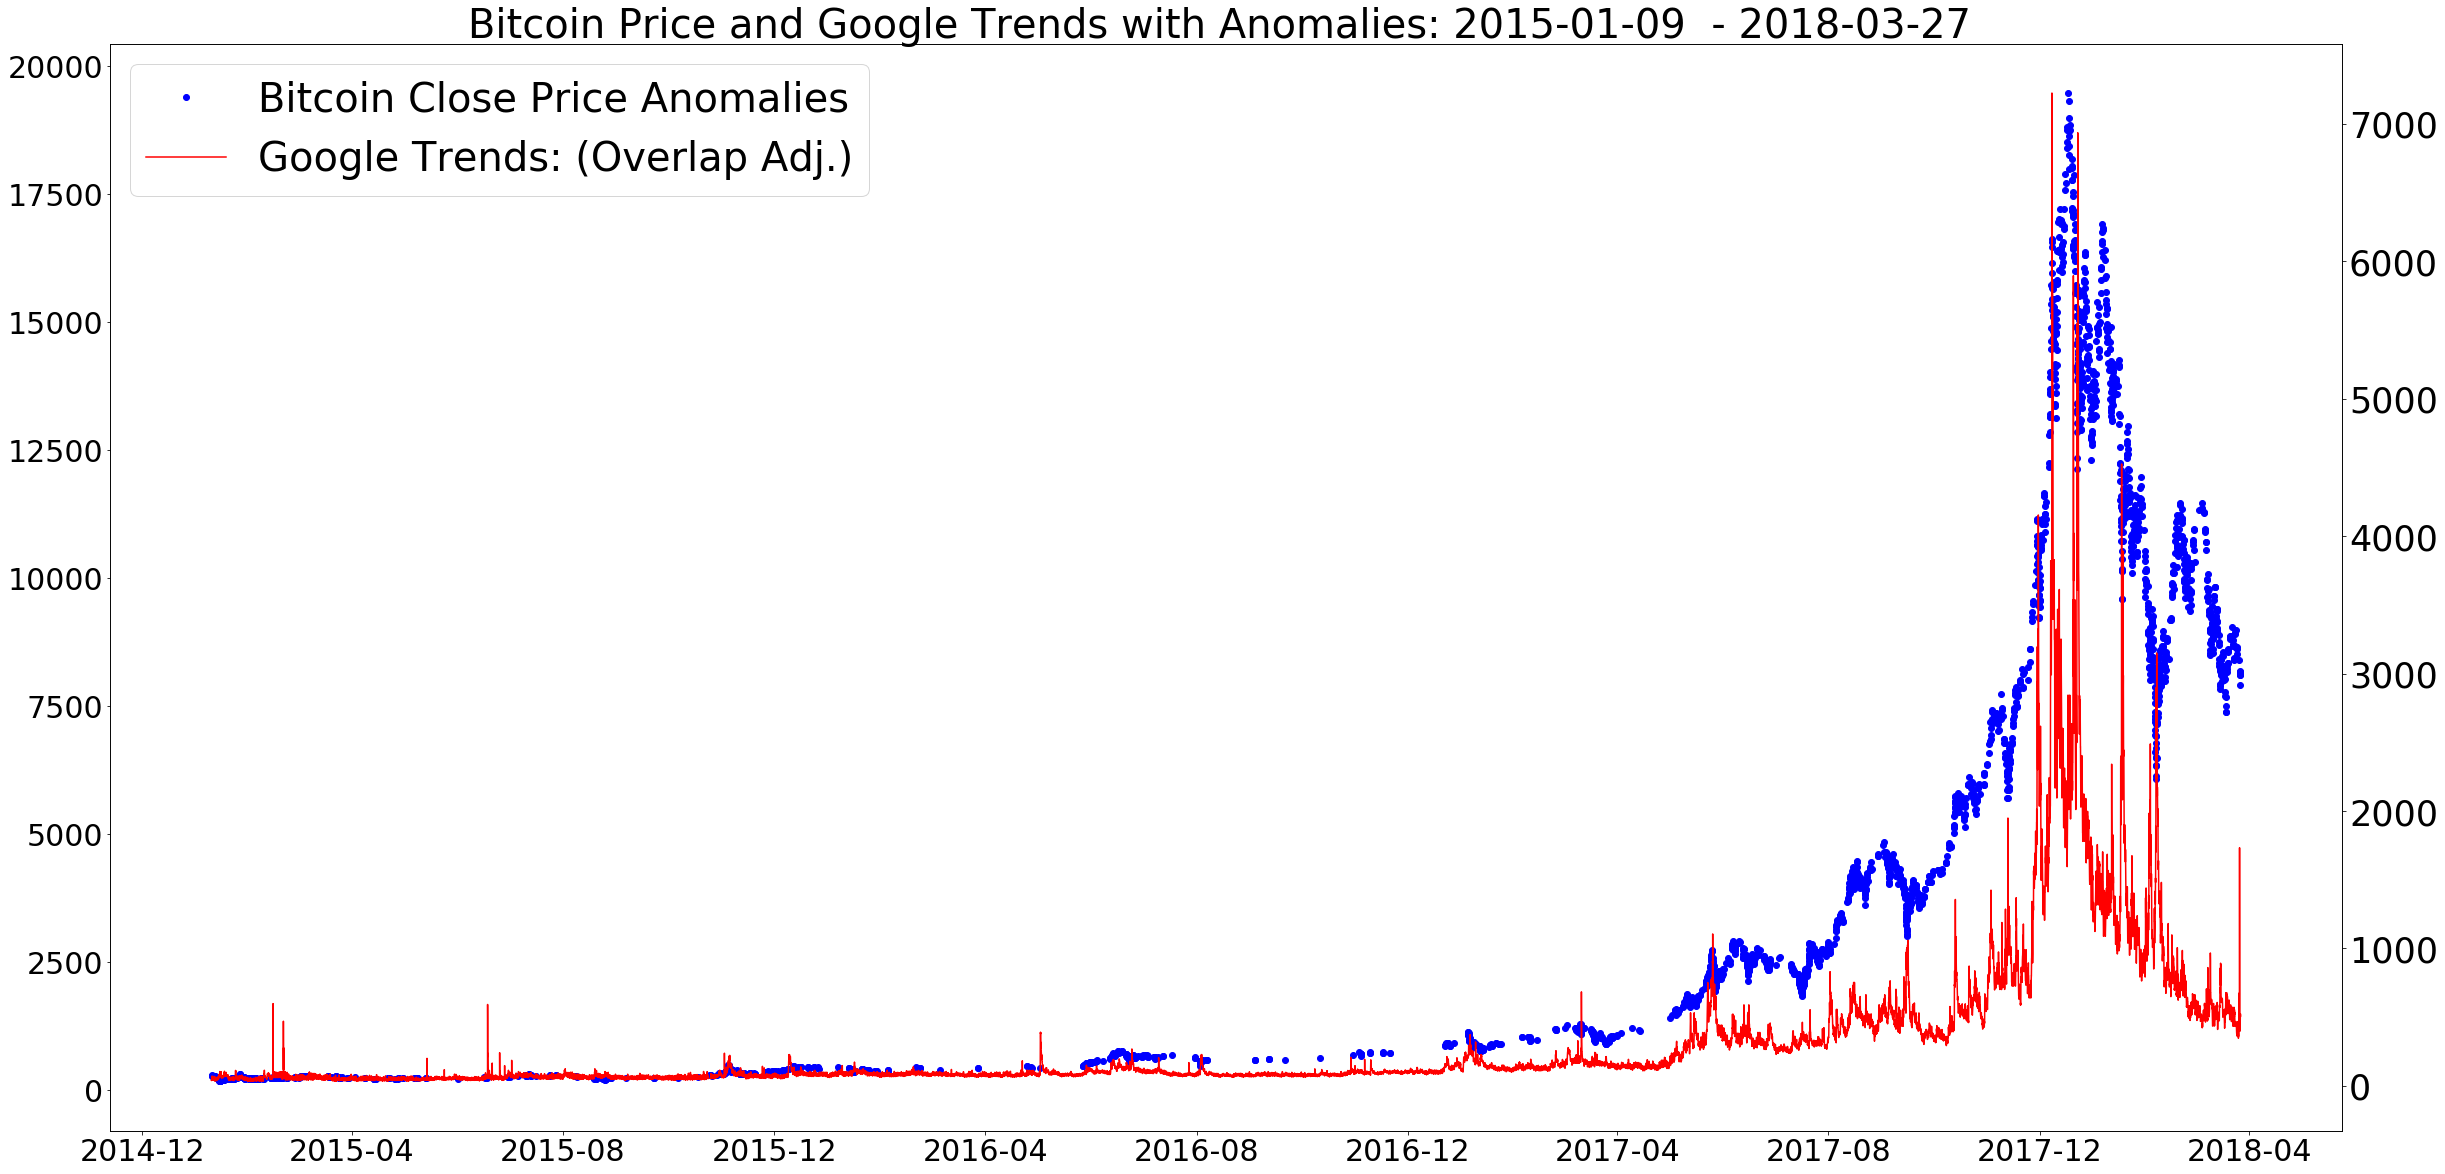

In [24]:
# Approach Anomaly Detection in a simple percent change approach 

MOVING_WINDOW_SIZE = 3

btc_and_trends_df_hourly_overlap['Moving Average Price'] = btc_and_trends_df_hourly_overlap["Close"].rolling(window=MOVING_WINDOW_SIZE).mean()
btc_and_trends_df_hourly_overlap["Moving Average Price % Change"] = btc_and_trends_df_hourly_overlap["Moving Average Price"].pct_change()
btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"] = btc_and_trends_df_hourly_overlap["Moving Average Price % Change"].abs() 

THRESHOLD_PERCENTILE = 0.9 

threshold_cutoff_value = btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"].quantile(THRESHOLD_PERCENTILE)
print('With a Percentile threshold of %f, the cutoff value is %f' %(THRESHOLD_PERCENTILE, threshold_cutoff_value) )

above_threshold_df = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"] >= threshold_cutoff_value]
display(above_threshold_df.head())
print('There are %i rows above threshold' % (len(above_threshold_df)))
display(btc_and_trends_df_hourly_overlap.tail())


# Graph it 
fig, ax = plt.subplots(figsize=(40,20)) 
l1, = ax.plot(above_threshold_df["Date(UTC)"], above_threshold_df["Close"], color='blue',linestyle="None", marker='o')
#l2, = ax.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Close"], color='#aad6cc')

ax2 = ax.twinx() 
l3, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )

ax.set_title('Bitcoin Price and Google Trends with Anomalies: ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_fontsize(30)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30)  

#plt.legend([l1, l2, l3],["Bitcoin Close Price Anomalies", "Bitcoin Close Price ", "Google Trends: (Overlap Adj.)"], fontsize=40)
plt.legend([l1, l3],["Bitcoin Close Price Anomalies", "Google Trends: (Overlap Adj.)"], fontsize=40)

plt.show();



In [25]:
# correlation

corr_close_and_overlap = btc_and_trends_df_hourly_overlap["Close"].corr(btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"])

print('Correlation between Close price and Trend (Overlap): ', corr_close_and_overlap)


Correlation between Close price and Trend (Overlap):  0.865874907069


## Granger Causality

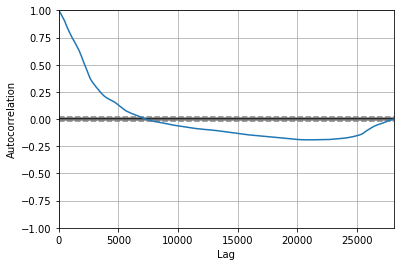

In [26]:
from pandas.plotting import autocorrelation_plot

# autocorrelation
plt.rcParams.update({'font.size':10})
autocorrelation_plot(btc_and_trends_df_hourly_overlap["Close"]);

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Process Data 
granger_df = btc_and_trends_df_hourly_overlap[["Close", "Bitcoin (Adj.Overlap)","Close Price % Change (Abs)" ]]
#granger_df.set_index("Timestamp", inplace=True)
granger_df = granger_df.dropna()
display(granger_df.head())

# turn data from non-stationary to stationary data

# Use log for non-linear trend
granger_df["Close Price % Change (Abs)"].loc[granger_df["Close Price % Change (Abs)"] == 0.000000] = 0.000001

data_matrix_array = np.diff(np.log(granger_df), axis=0)


# #data_matrix_array = np.diff(granger_df, axis=0)

# def convert_to_stationary(x):
#     if (x["Close Price % Change (Abs)"] == 0 ):
#         return None
#     else:
#         return np.log(x)

# #data_matrix_array = np.log(granger_df)
# data_matrix_array = granger_df.apply(convert_to_stationary, axis=1)

data_matrix = pd.DataFrame(data_matrix_array, columns = ["Close", "Bitcoin (Adj.Overlap)","Close Price % Change (Abs)"])
data_matrix["Bitcoin (Adj.Overlap)"].loc[data_matrix["Bitcoin (Adj.Overlap)"] == 0.000000] = 0.000001
data_matrix["Close Price % Change (Abs)"].loc[data_matrix["Close Price % Change (Abs)"] == 0.000000] = 0.000001
#data_matrix = data_matrix.dropna()
print("Transformed Data")
display(data_matrix.head())

Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)
1  292.15                   41.0                    0.010445
2  293.89                   43.0                    0.005956
3  289.10                   43.0                    0.016299
4  288.59                   45.0                    0.001764
5  286.70                   53.0                    0.006549

Transformed Data


Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)
0  0.005938               0.047628                   -0.561763
1 -0.016433               0.000001                    1.006707
2 -0.001766               0.045462                   -2.223442
3 -0.006571               0.163629                    1.311687
4  0.005808              -0.019048                   -0.117183

In [28]:
# from statsmodels.tsa.stattools import coint

# coint_result = coint(data_matrix[])

In [29]:
# writer = pd.ExcelWriter("data_matrix.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# data_matrix.to_excel(writer)
# writer.save()

In [30]:
# Test if data is now stationary using Augmented Dickey-Fuller unit root test (Adfuller)
results = [] 
results.append(adfuller(granger_df["Close"].values, regression='nc'))
results.append(adfuller(granger_df["Bitcoin (Adj.Overlap)"].values, regression='nc'))
results.append(adfuller(granger_df["Close Price % Change (Abs)" ].values, regression='nc'))
results.append(adfuller(data_matrix["Close"], regression='nc'))
results.append(adfuller(data_matrix["Bitcoin (Adj.Overlap)"], regression='nc'))
results.append(adfuller(data_matrix["Close Price % Change (Abs)" ], regression='nc'))
results_labels = ['Price with w/o difference', 'Bitcoin trend w/o difference', 'Close Price % Change (Abs) w/o difference',          
                  'Price with w/ difference', 'Bitcoin trend w/ difference', 'Close Price % Change (Abs) w/ difference']


for i, result in enumerate(results):
    print('-----------------------')
    print(results_labels[i])              
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

granger_test_result = grangercausalitytests(data_matrix[["Close", "Bitcoin (Adj.Overlap)"]], 15)

print('If I make data into stationary by just differencing, then all of the p-values are 0 or near 0')

-----------------------
Price with w/o difference
ADF Statistic: -0.406113
p-value: 0.534265
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941
-----------------------
Bitcoin trend w/o difference
ADF Statistic: -4.083979
p-value: 0.000052
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941
-----------------------
Close Price % Change (Abs) w/o difference
ADF Statistic: -6.493781
p-value: 0.000000
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941
-----------------------
Price with w/ difference
ADF Statistic: -31.210080
p-value: 0.000000
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941
-----------------------
Bitcoin trend w/ difference
ADF Statistic: -27.397975
p-value: 0.000000
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941
-----------------------
Close Price % Change (Abs) w/ difference
ADF Statistic: -36.929010
p-value: 0.000000
Critical Values:
	1%: -2.566
	10%: -1.617
	5%: -1.941

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1072

In [31]:
# Now test if Close Prices Granger Causes Google Trends 

close_prices_stationary = data_matrix["Close"]
bitcoin_trends_stationary = data_matrix["Bitcoin (Adj.Overlap)"]
data_matrix_2 = np.column_stack(( bitcoin_trends_stationary, close_prices_stationary))
display(data_matrix_2)

granger_test_result = grangercausalitytests(data_matrix_2, 30)

array([[  4.76280490e-02,   5.93817867e-03],
       [  1.00000000e-06,  -1.64328986e-02],
       [  4.54623741e-02,  -1.76565332e-03],
       ..., 
       [  1.00000000e-06,  -1.39514259e-03],
       [ -3.39015517e-02,   3.76415138e-02],
       [  3.39015517e-02,  -3.45164222e-03]])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5864  , p=0.4438  , df_denom=28074, df_num=1
ssr based chi2 test:   chi2=0.5865  , p=0.4438  , df=1
likelihood ratio test: chi2=0.5865  , p=0.4438  , df=1
parameter F test:         F=0.5864  , p=0.4438  , df_denom=28074, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0214  , p=0.3601  , df_denom=28071, df_num=2
ssr based chi2 test:   chi2=2.0431  , p=0.3600  , df=2
likelihood ratio test: chi2=2.0431  , p=0.3600  , df=2
parameter F test:         F=1.0214  , p=0.3601  , df_denom=28071, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7018  , p=0.5509  , df_denom=28068, df_num=3
ssr based chi2 test:   chi2=2.1058  , p=0.5507  , df=3
likelihood ratio test: chi2=2.1057  , p=0.5508  , df=3
parameter F test:         F=0.7018  , p=0.5509  , df_denom=28068, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5803  

ssr based F test:         F=4.6906  , p=0.0000  , df_denom=27993, df_num=28
ssr based chi2 test:   chi2=131.6053, p=0.0000  , df=28
likelihood ratio test: chi2=131.2975, p=0.0000  , df=28
parameter F test:         F=4.6906  , p=0.0000  , df_denom=27993, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=4.5277  , p=0.0000  , df_denom=27990, df_num=29
ssr based chi2 test:   chi2=131.5793, p=0.0000  , df=29
likelihood ratio test: chi2=131.2716, p=0.0000  , df=29
parameter F test:         F=4.5277  , p=0.0000  , df_denom=27990, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=4.5050  , p=0.0000  , df_denom=27987, df_num=30
ssr based chi2 test:   chi2=135.4434, p=0.0000  , df=30
likelihood ratio test: chi2=135.1174, p=0.0000  , df=30
parameter F test:         F=4.5050  , p=0.0000  , df_denom=27987, df_num=30


### Granger Causality Observations

#### If Google Trends Granger Causes Bitcoin Prices 

#### If Bitcoin Prices Granger Causes Google Trends 


## Structural VARs

Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)
0  0.005938               0.047628                   -0.561763
1 -0.016433               0.000001                    1.006707
2 -0.001766               0.045462                   -2.223442
3 -0.006571               0.163629                    1.311687
4  0.005808              -0.019048                   -0.117183

array([['1', '1'],
       ['E', '1']],
      dtype='<U11')

array([['E', '0'],
       ['0', 'E']],
      dtype='<U1')

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 14, Jun, 2018
Time:                     17:41:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4015
Nobs:                     28077.0    HQIC:                  -14.4023
Log likelihood:           122517.    FPE:                5.55904e-07
AIC:                     -14.4027    Det(Omega_mle):     5.55824e-07
--------------------------------------------------------------------
Results for equation Close
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
L1.Close                        -0.053238         0.005960           -8.933           0.000
L1.Bitcoin (Adj.Overlap)         0.000210         0.000637            0.330           0.742

Results for equ

Granger Causality: Close -> Google Trend
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    0.1088         3.842       0.742  (1, 56150)
------------------------------------------------
Instantaneous causality Wald-test. H_0: Bitcoin (Adj.Overlap) does not instantaneously cause Close. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    0.1436         3.841       0.705  1 
----------------------------------------


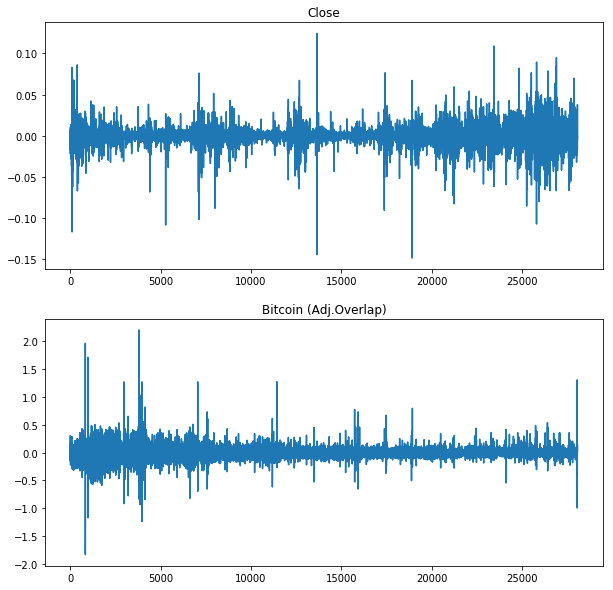

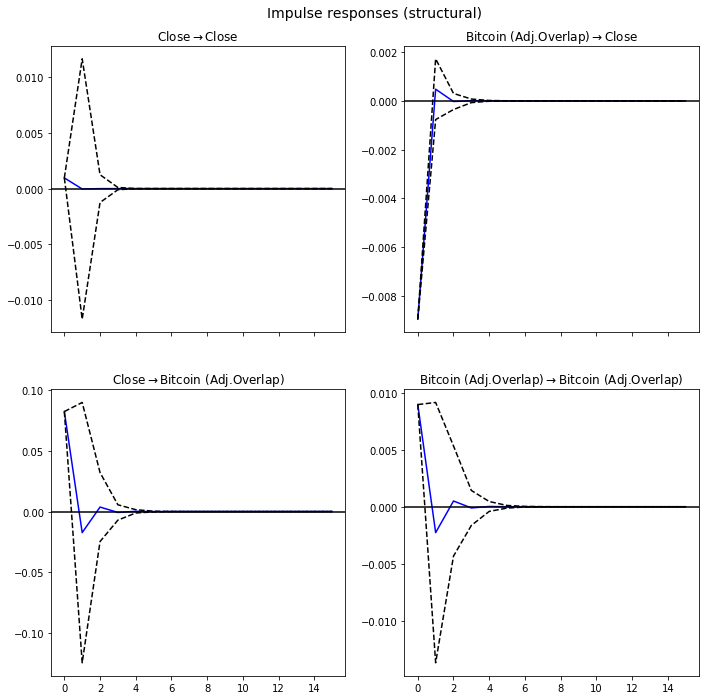

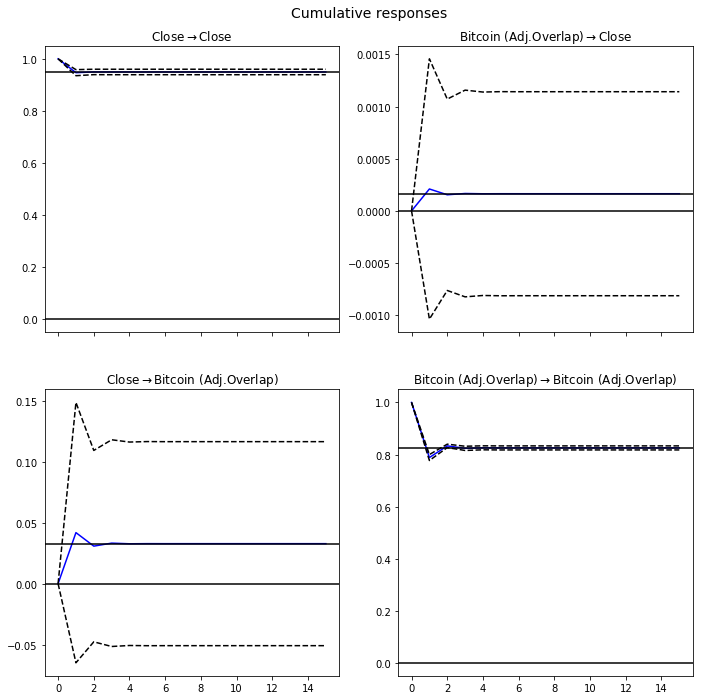

In [54]:
from statsmodels.tsa.api import SVAR 


"""

https://www.researchgate.net/file.PostFileLoader.html?id=514b37aed3df3e9a08000047&assetKey=AS%3A271834451251200%401441821791671

A-matrix imposes restrictions on the off-diagonal terms. 
The diagonal terms reflect the unit change of element i on i or on itself e.g. if defense spending increases
this should have a 1:1 response = you will see a 1 for diagonal terms. Same for GDP.

A = [[ i -> i,   j -> i],
     [ i -> j,   j -> j]]
       
       i.e.    i = defense spending, j = GDP
               -> 0 means no effect. so if j->i = 0, it means that GDP has no effect on defense spending

My case: 

let i = Close Price, j = Google Trends 

A = [[ 1, 1 ]
     ['E',1 ]]

    -> Assumption: Google Trends has effect on Close Price (j->i = 1)


B = [['E', 0  ],
     [ 0 ,'E']]



"""


A = np.array([[ 1 , 1], 
              ['E', 1]])

B = np.array([['E',0], 
              [0, 'E']])

display(data_matrix.head(), A, B )

# TODO: Look and tweak parameters 

SVAR_model = SVAR(data_matrix[["Close", "Bitcoin (Adj.Overlap)"]], svar_type='AB', A=A, B=B)
#SVAR_model = SVAR(data_matrix[["Close", "Bitcoin (Adj.Overlap)"]], svar_type='A', A=A)
result_SVAR = SVAR_model.fit(verbose=True, trend='nc')
display(result_SVAR.summary())


result_SVAR.plot();
SVAR_irf = result_SVAR.irf(periods=15)
SVAR_irf.plot();
SVAR_irf.plot_cum_effects();

SVAR_granger_result = result_SVAR.test_causality('Close', 'Bitcoin (Adj.Overlap)', kind='f')
print('Granger Causality: Close -> Google Trend')
print(SVAR_granger_result.summary())
SVAR_instantaneous_causality_result = result_SVAR.test_inst_causality('Bitcoin (Adj.Overlap)')
print(SVAR_instantaneous_causality_result.summary())

In [33]:
# Test if Prices Granger Causes Trend 
SVAR_granger_result = result_SVAR.test_causality('Bitcoin (Adj.Overlap)', 'Close', kind='f')
print("Granger Causality: Google Trend -> Price")
print(SVAR_granger_result.summary())

Granger Causality: Google Trend -> Price
Granger causality F-test. H_0: Close does not Granger-cause Bitcoin (Adj.Overlap). Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    0.5908         3.842       0.442  (1, 56150)
------------------------------------------------


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 14, Jun, 2018
Time:                     17:41:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.01605
Nobs:                     28077.0    HQIC:                  -4.01685
Log likelihood:          -23279.2    FPE:                  0.0180028
AIC:                     -4.01723    Det(Omega_mle):       0.0180002
--------------------------------------------------------------------
Results for equation Close Price % Change (Abs)
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
L1.Close Price % Change (Abs)        -0.488391         0.005208          -93.775           0.000
L1.Bitcoin (Adj.Overlap)             -0.084172         0.114629         

-----------------------------------------------------
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close Price % Change (Abs). Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    0.5392         3.842       0.463  (1, 56150)
------------------------------------------------
Instantaneous causality Wald-test. H_0: Bitcoin (Adj.Overlap) does not instantaneously cause Close Price % Change (Abs). Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    2.333          3.841       0.127  1 
----------------------------------------


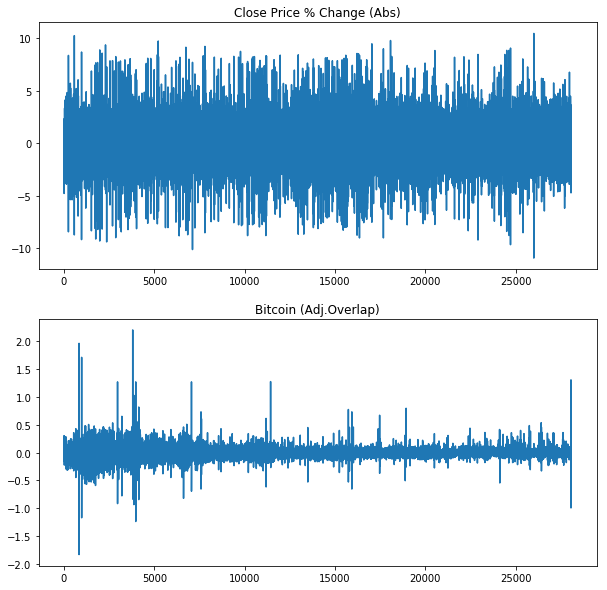

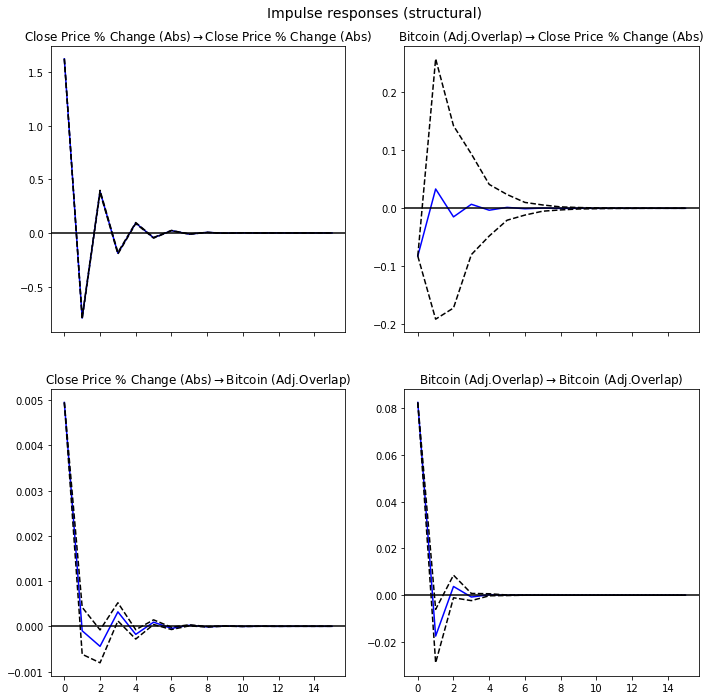

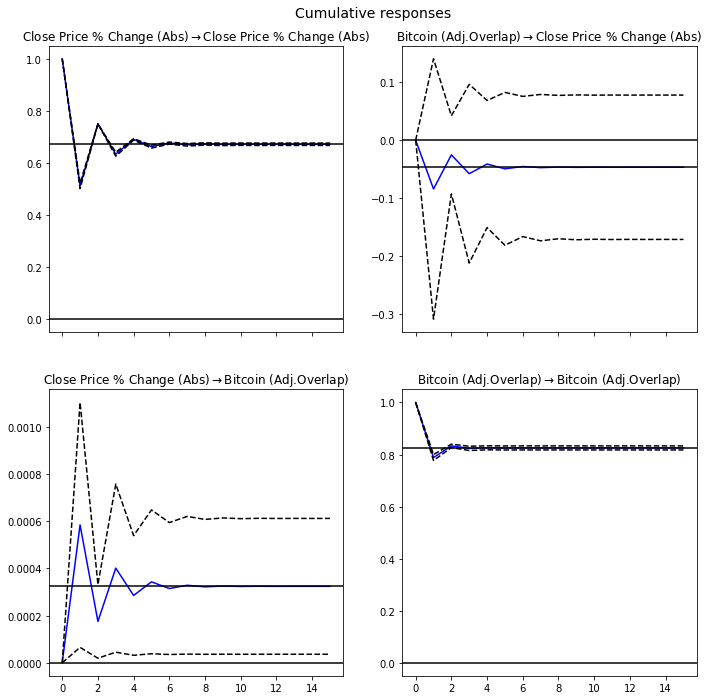

In [55]:
# Run SVAR for price % change

SVAR_model_percent_change = SVAR(data_matrix[["Close Price % Change (Abs)", "Bitcoin (Adj.Overlap)"]], svar_type='AB', A=A, B=B)
percent_change_result_SVAR = SVAR_model_percent_change.fit(verbose=True, trend='nc')

# NOTE: ERROR HAPPENS PROBABLY FROM 0s IN THE DATA 

display(percent_change_result_SVAR.summary())
percent_change_result_SVAR.plot();
SVAR_irf_percent_change = percent_change_result_SVAR.irf(periods=15)
SVAR_irf_percent_change.plot();
SVAR_irf_percent_change.plot_cum_effects();

SVAR_granger_percent_change_result = percent_change_result_SVAR.test_causality('Close Price % Change (Abs)', 'Bitcoin (Adj.Overlap)', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_percent_change_result.summary())
SVAR_instantaneous_causality_percent_change_result = percent_change_result_SVAR.test_inst_causality('Bitcoin (Adj.Overlap)')
print(SVAR_instantaneous_causality_percent_change_result.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 14, Jun, 2018
Time:                     17:42:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.82249
Nobs:                     3454.00    HQIC:                  -4.82707
Log likelihood:          -1457.29    FPE:                 0.00798965
AIC:                     -4.82961    Det(Omega_mle):      0.00798041
--------------------------------------------------------------------
Results for equation Close Price % Change (Abs)
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
L1.Close Price % Change (Abs)        -0.512725         0.014616          -35.079           0.000
L1.Bitcoin (Adj.Overlap)              0.267496         0.446857         

-----------------------------------------------------
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close Price % Change (Abs). Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    0.3583         3.843       0.549  (1, 6904)
-----------------------------------------------
Instantaneous causality Wald-test. H_0: Bitcoin (Adj.Overlap) does not instantaneously cause Close Price % Change (Abs). Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    3.036          3.841       0.081  1 
----------------------------------------


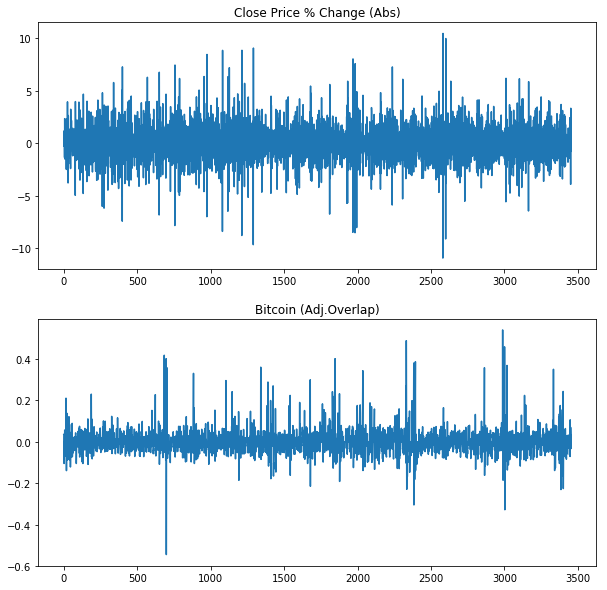

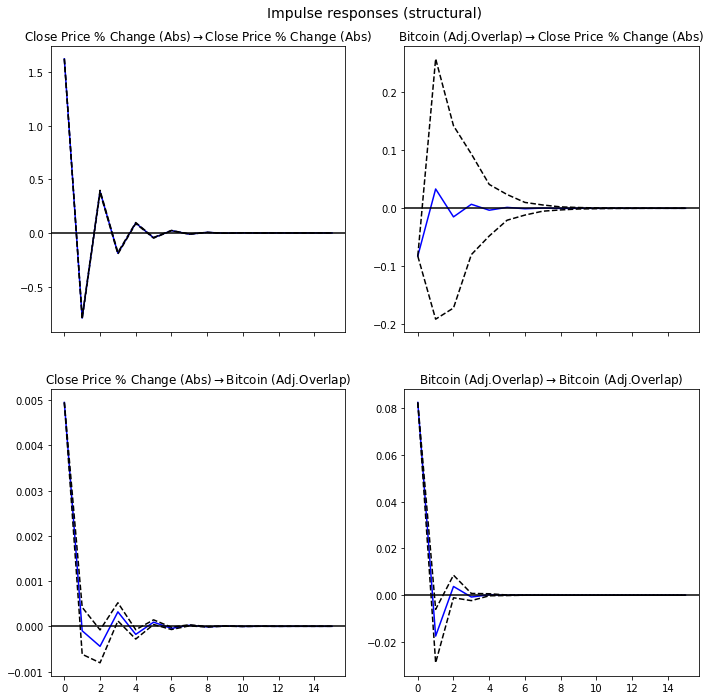

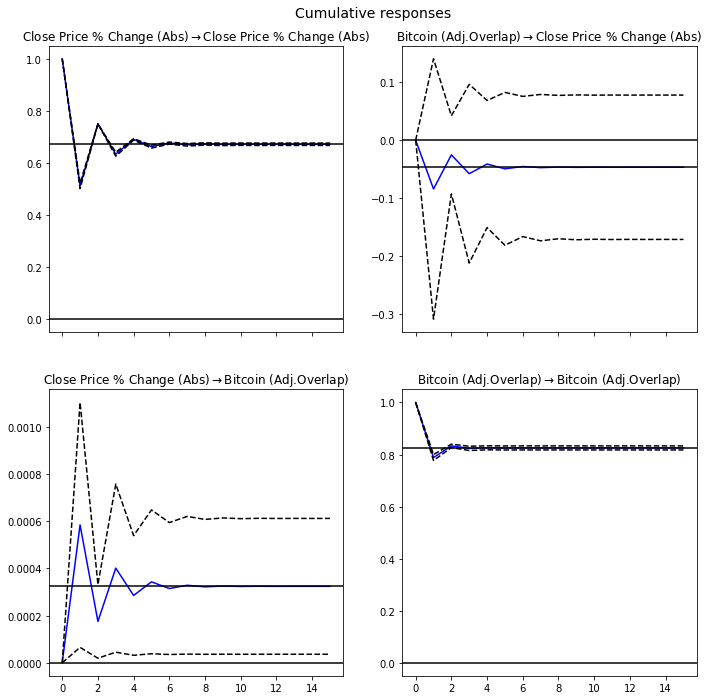

In [56]:
# see if SVAR works for sep_2017_to_feb_2018_overlap_df

# for Price % Change

# get row indexes for sep 2017 to feb 2018 
sep_2017_index = sep_2017_to_feb_2018_overlap_df.iloc[0].name 
feb_2018_index = sep_2017_to_feb_2018_overlap_df.iloc[-1].name 

SVAR_model_spike = SVAR(data_matrix[["Close Price % Change (Abs)", "Bitcoin (Adj.Overlap)"]].iloc[sep_2017_index:feb_2018_index], svar_type='AB', A=A, B=B)
spike_result_SVAR = SVAR_model_spike.fit(verbose=True, trend='nc')

display(spike_result_SVAR.summary())
spike_result_SVAR.plot();
SVAR_irf_spike = percent_change_result_SVAR.irf(periods=15)
SVAR_irf_spike.plot();
SVAR_irf_spike.plot_cum_effects();

SVAR_granger_spike_result = spike_result_SVAR.test_causality('Close Price % Change (Abs)', 'Bitcoin (Adj.Overlap)', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_spike_result.summary())
SVAR_instantaneous_causality_spike_result = spike_result_SVAR.test_inst_causality('Bitcoin (Adj.Overlap)')
print(SVAR_instantaneous_causality_spike_result.summary())


In [35]:
# TODO: See if any of the VAR models work for just during the recent spike 
# TODO: Instead of getting correlation when there is also an anomaly get correlations for every time period

# Question: Is there a such thing as "over-converting" to stationary data? 